 Step 1:

Data Acquisition

Downloading Data form Kaggle

In [ ]:
import kagglehub

# Download dataset
path = kagglehub.dataset_download("pratikbarua/vehicle-detection-dataset")
print("Dataset downloaded to:", path)


100%|██████████| 1.39G/1.39G [00:09<00:00, 158MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1


Step 2:

Installing and importing needed libraries

In [ ]:
!pip install --quiet kagglehub ultralytics tqdm xmltodict opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.5 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import xmltodict
from tqdm import tqdm
from ultralytics import YOLO
import shutil
import random
from pathlib import Path
import xml.etree.ElementTree as ET
from tqdm import tqdm


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Step 3:

Configuration Settings

This section defines the project configuration parameters

In [ ]:
# Configuration settings for Vehicle Detection Project
DATASET_ROOT = '/root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset'
CHOSEN_CLASSES = ['car', 'bus', 'motorbike', 'rickshaw']
OUTPUT_DIR = '/content/vehicle_dataset'
IMG_EXTENSIONS = {'.jpg', '.jpeg', '.png'}
TRAIN_RATIO = 0.75
RANDOM_SEED = 42
YOLO_MODEL = 'yolov8m.pt'
EPOCHS = 50
BATCH = 16
IMG_SIZE = 640

Step 4:

Directory Setup and paring images with their annotations


In [ ]:
from pathlib import Path

# Dataset root
root = Path(
    "/root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1"
)

# Define train and test directories
train_dir = root / "train"
test_dir = root / "test1"

# Training images and annotations directories
train_images_dir = train_dir / "Final Train Dataset"
train_ann_dir = train_dir / "Final Train Dataset"


def collect_pairs(images_dir, ann_dir):
    """
    Collect image-annotation pairs based on matching file stems.

    Args:
        images_dir (Path): Directory containing image files.
        ann_dir (Path): Directory containing XML annotation files.

    Returns:
        list[tuple[Path, Path]]: List of (image_path, annotation_path) pairs.
    """
    img_exts = {".jpg", ".jpeg", ".png"}
    image_files = [p for p in images_dir.rglob("*") if p.suffix.lower() in img_exts]
    xml_files = {p.stem: p for p in ann_dir.rglob("*.xml")}

    pairs = []
    for img in image_files:
        stem = img.stem
        if stem in xml_files:
            pairs.append((img, xml_files[stem]))
        else:
            # Try partial name matching
            matched = next(
                (v for k, v in xml_files.items() if k in stem or stem in k), None
            )
            if matched:
                pairs.append((img, matched))

    return pairs


# Collect training pairs
train_pairs = collect_pairs(train_images_dir, train_ann_dir)
print(f"Train pairs found: {len(train_pairs)}")

# Collect test images (no annotations)
img_exts = {".jpg", ".jpeg", ".png"}
test_images_dir = test_dir
test_images = [
    p for p in test_images_dir.rglob("*") if p.suffix.lower() in img_exts
]
print(f"Test images found: {len(test_images)}")


Train pairs found: 3003
Test images found: 500


Step 5:

scans all annotations to understand the dataset's class distribution and focus on the chosen classes

In [ ]:
import os
import xmltodict
from collections import Counter

# Store all unique class names
all_classes = set()

# Store counts for the chosen classes
class_counts = Counter()

for _, xml_path in train_pairs:
    # Skip missing or empty annotation files
    if not os.path.exists(xml_path) or os.path.getsize(xml_path) == 0:
        print(f"Warning: Skipping empty or missing XML file: {xml_path}")
        continue

    try:
        with open(xml_path, 'r', encoding='utf-8') as file:
            data = xmltodict.parse(file.read())
    except Exception as err:
        print(f"Warning: Failed to parse {xml_path} with error: {err}")
        continue

    # Extract objects from the annotation
    objects = data['annotation'].get('object', [])
    if not objects:
        continue

    # If only one object, wrap it into a list for consistency
    if isinstance(objects, dict):
        objects = [objects]

    for obj in objects:
        class_name = obj['name'].lower().strip()
        all_classes.add(class_name)

        # Only count if in chosen classes
        if class_name in CHOSEN_CLASSES:
            class_counts[class_name] += 1

# Output results
print("All classes found in dataset:")
print(sorted(all_classes))

print("\nCounts of chosen classes:")
print(class_counts)


All classes found in dataset:
['ambulance', 'army vehicle', 'auto rickshaw', 'bicycle', 'bus', 'car', 'garbagevan', 'human hauler', 'minibus', 'minivan', 'motorbike', 'pickup', 'policecar', 'rickshaw', 'scooter', 'suv', 'taxi', 'three wheelers (cng)', 'truck', 'van', 'wheelbarrow']

Counts of chosen classes:
Counter({'car': 5476, 'rickshaw': 3549, 'bus': 3340, 'motorbike': 2284})


Interpretation

The result indicates the total number of unique classes in the dataset and the counts of the classes that were selected.

Step 6:

In this step of the code, analyzing the training dataset annotations to understand the distribution of object classes and bounding box sizes.

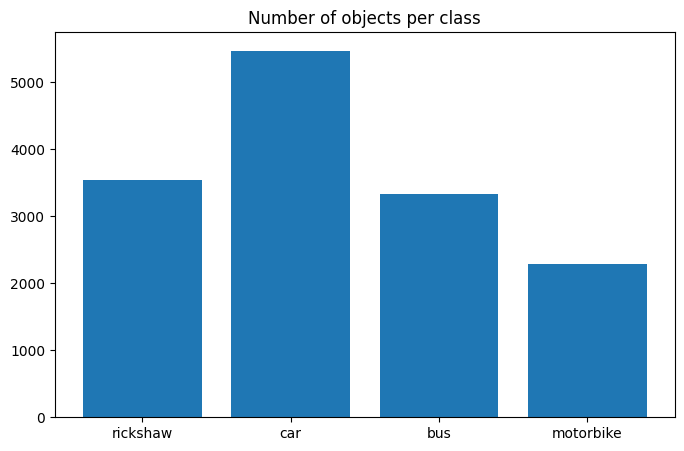

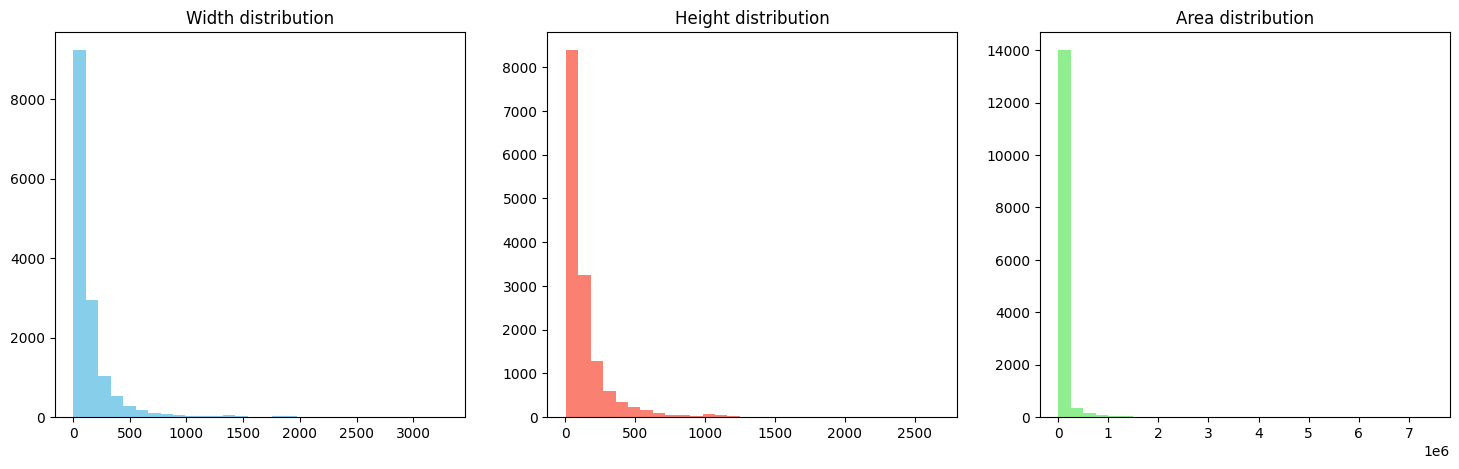

In [ ]:
import xmltodict
from collections import Counter
import matplotlib.pyplot as plt
import os

areas = []
widths = []
heights = []
class_counts = Counter()

for img_path, xml_path in train_pairs:
    # Check if the file exists and is not empty
    if not os.path.exists(xml_path) or os.path.getsize(xml_path) == 0:
        print(f"Warning: Skipping empty or missing XML file: {xml_path}")
        continue

    try:
        with open(xml_path, 'r') as f:
            data = xmltodict.parse(f.read())
    except Exception as e:
        print(f"Warning: Failed to parse {xml_path} with error: {e}")
        continue


    objects = data['annotation'].get('object', [])
    if isinstance(objects, dict):
        objects = [objects]

    for obj in objects:
        class_name = obj['name'].lower()
        if class_name in CHOSEN_CLASSES:
            class_counts[class_name] += 1

            bbox = obj['bndbox']
            xmin, ymin = int(bbox['xmin']), int(bbox['ymin'])
            xmax, ymax = int(bbox['xmax']), int(bbox['ymax'])
            w = xmax - xmin
            h = ymax - ymin
            area = w * h

            widths.append(w)
            heights.append(h)
            areas.append(area)

# Plot class counts
plt.figure(figsize=(8,5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Number of objects per class')
plt.show()

# Plot width, height, and area histograms
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.hist(widths, bins=30, color='skyblue')
plt.title('Width distribution')

plt.subplot(1,3,2)
plt.hist(heights, bins=30, color='salmon')
plt.title('Height distribution')

plt.subplot(1,3,3)
plt.hist(areas, bins=30, color='lightgreen')
plt.title('Area distribution')

plt.show()

Interpretation

The height, width, and area of the bounding boxes are mostly positively skewed, indicating that most objects are smaller in size with a few significantly larger ones. The object count per class visualization shows that the car class has the highest number of annotated objects and motor bike has lowest number of annotated objects from the selected classes in the dataset, suggesting a class imbalance that could influence model performance.

Step 7:

Convert XML annotation to YOLO txt format

In [ ]:
def convert_xml_to_yolo(xml_path, label_path, classes):
    try:
        with open(xml_path, 'r') as f:
            data = xmltodict.parse(f.read())
    except Exception as e:
        print(f"Warning: Failed to parse {xml_path} with error: {e}")
        return

    img_width = int(data['annotation']['size']['width'])
    img_height = int(data['annotation']['size']['height'])

    if img_width == 0 or img_height == 0:
        print(f"Warning: Invalid image size in {xml_path} - skipping")
        return

    objects = data['annotation'].get('object', [])
    if isinstance(objects, dict):
        objects = [objects]

    lines = []
    for obj in objects:
        class_name = obj['name'].lower()
        if class_name not in classes:
            continue
        class_id = class2id[class_name]
        bbox = obj['bndbox']
        xmin = int(bbox['xmin'])
        ymin = int(bbox['ymin'])
        xmax = int(bbox['xmax'])
        ymax = int(bbox['ymax'])

        x_center = ((xmin + xmax) / 2) / img_width
        y_center = ((ymin + ymax) / 2) / img_height
        width = (xmax - xmin) / img_width
        height = (ymax - ymin) / img_height

        lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    with open(label_path, 'w') as f:
        f.write('\n'.join(lines) if lines else '')

Selecting classes which to detect

In [ ]:

classes = ['car', 'bus', 'motorbike', 'rickshaw']
class2id = {cls_name: idx for idx, cls_name in enumerate(classes)}


Step 8:

 Prepare output directories

In [ ]:
output_root = Path(OUTPUT_DIR)
(images_root := output_root / 'images').mkdir(parents=True, exist_ok=True)
(labels_root := output_root / 'labels').mkdir(parents=True, exist_ok=True)

for split in ['train', 'val']:
    (images_root / split).mkdir(exist_ok=True)
    (labels_root / split).mkdir(exist_ok=True)

Step 9:

Split dataset and copy files

In [ ]:
random.seed(RANDOM_SEED)
random.shuffle(train_pairs)
split_idx = int(len(train_pairs) * TRAIN_RATIO)
train_split = train_pairs[:split_idx]
val_split = train_pairs[split_idx:]

print(f"Train samples: {len(train_split)}, Val samples: {len(val_split)}")

def copy_split(pairs, split):
    for img_path, xml_path in tqdm(pairs, desc=f"Processing {split} split"):
        label_file = Path(fa"{img_path.stem}.txt")

        dst_img_path = images_root / split / img_path.name
        shutil.copy(img_path, dst_img_path)

        dst_label_path = labels_root / split / label_file
        if xml_path.exists() and xml_path.stat().st_size > 0:
            convert_xml_to_yolo(xml_path, dst_label_path, CHOSEN_CLASSES)
        else:
            with open(dst_label_path, 'w') as f:
                f.write('')

copy_split(train_split, 'train')
copy_split(val_split, 'val')

Train samples: 2252, Val samples: 751


Processing train split:   7%|▋         | 151/2252 [00:00<00:10, 205.29it/s]

Processing train split:  31%|███▏      | 708/2252 [00:03<00:08, 187.40it/s]

Processing val split: 100%|██████████| 751/751 [00:02<00:00, 279.57it/s]


Step 10:

Create data.yaml for YOLOv8

In [ ]:
data_yaml = f"""
train: {str(images_root / 'train')}
val: {str(images_root / 'val')}

nc: {len(CHOSEN_CLASSES)}
names: {CHOSEN_CLASSES}
"""

yaml_path = output_root / 'data.yaml'
yaml_path.write_text(data_yaml)
print(f"Created data.yaml at {yaml_path}")

Created data.yaml at /content/vehicle_dataset/data.yaml


Step 11:

Train YOLOv8 model

In [ ]:
from ultralytics import YOLO

model = YOLO(YOLO_MODEL)

results = model.train(
    data=str(yaml_path),
    epochs=EPOCHS,
    batch=BATCH,
    imgsz=IMG_SIZE,
    name='vehicle_detection_exp',
    save=True,
)

Ultralytics 8.3.176 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/vehicle_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=vehicle_detection_exp, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True,

Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

 16                  -1  1    332160  ultralytics.nn.modules.conv.Conv             [192, 192, 3, 2]              
 17            [-1, 12]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 18                  -1  2   1846272  ultralytics.nn.modules.block.C2f             [576, 384, 2]                 
 19                  -1  1   1327872  ultralytics.nn.modules.conv.Conv             [384, 384, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 21                  -1  2   4207104  ultralytics.nn.modules.block.C2f             [960, 576, 2]                 
 22        [15, 18, 21]  1   3778012  ultralytics.nn.modules.head.Detect           [4, [192, 384, 576]]          
Model summary: 169 layers, 25,858,636 parameters, 25,858,620 gradients, 79.1 GFLOPs

Transferred 469/475 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mi

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2231.0±1133.4 MB/s, size: 336.0 KB)


train: Scanning /content/vehicle_dataset/labels/train... 2249 images, 234 backgrounds, 0 corrupt: 100%|██████████| 2252/2252 [00:10<00:00, 208.28it/s] 

train: /content/vehicle_dataset/images/train/150.jpg: corrupt JPEG restored and saved
train: /content/vehicle_dataset/images/train/151.jpg: corrupt JPEG restored and saved
train: /content/vehicle_dataset/images/train/152.jpg: corrupt JPEG restored and saved
train: /content/vehicle_dataset/images/train/153.jpg: corrupt JPEG restored and saved
train: /content/vehicle_dataset/images/train/155.jpg: corrupt JPEG restored and saved
train: /content/vehicle_dataset/images/train/156.jpg: corrupt JPEG restored and saved
train: /content/vehicle_dataset/images/train/157.jpg: corrupt JPEG restored and saved
train: /content/vehicle_dataset/images/train/159.jpg: corrupt JPEG restored and saved
train: /content/vehicle_dataset/images/train/160.jpg: corrupt JPEG restored and saved
train: /content/vehicle_dataset/images/train/161.jpg: corrupt JPEG restored and saved
train: /content/vehicle_dataset/images/train/162.jpg: corrupt JPEG restored and saved
train: /content/vehicle_dataset/images/train/163.jpg: 

train: New cache created: /content/vehicle_dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1237.4±1227.0 MB/s, size: 353.6 KB)


val: Scanning /content/vehicle_dataset/labels/val... 751 images, 65 backgrounds, 0 corrupt: 100%|██████████| 751/751 [00:06<00:00, 120.20it/s]

val: /content/vehicle_dataset/images/val/144.jpg: corrupt JPEG restored and saved
val: /content/vehicle_dataset/images/val/145.jpg: corrupt JPEG restored and saved
val: /content/vehicle_dataset/images/val/146.jpg: corrupt JPEG restored and saved
val: /content/vehicle_dataset/images/val/147.jpg: corrupt JPEG restored and saved
val: /content/vehicle_dataset/images/val/148.jpg: corrupt JPEG restored and saved
val: /content/vehicle_dataset/images/val/149.jpg: corrupt JPEG restored and saved
val: /content/vehicle_dataset/images/val/154.jpg: corrupt JPEG restored and saved
val: /content/vehicle_dataset/images/val/158.jpg: corrupt JPEG restored and saved
val: /content/vehicle_dataset/images/val/168.jpg: corrupt JPEG restored and saved
val: /content/vehicle_dataset/images/val/169.jpg: corrupt JPEG restored and saved
val: /content/vehicle_dataset/images/val/171.jpg: corrupt JPEG restored and saved
val: /content/vehicle_dataset/images/val/176.jpg: corrupt JPEG restored and saved
val: /content/ve

Plotting labels to runs/detect/vehicle_detection_exp/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/vehicle_detection_exp
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.16G       1.32      1.762      1.182        108        640: 100%|██████████| 141/141 [01:18<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.54it/s]


                   all        751       3978      0.507        0.4      0.396      0.216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.36G      1.434      1.509      1.271        104        640: 100%|██████████| 141/141 [01:14<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.67it/s]


                   all        751       3978       0.47      0.425      0.393      0.214

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       6.4G      1.479      1.523      1.299        164        640: 100%|██████████| 141/141 [01:15<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.62it/s]


                   all        751       3978      0.562      0.414      0.424      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.45G      1.476      1.467      1.295         99        640: 100%|██████████| 141/141 [01:14<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.68it/s]


                   all        751       3978      0.557      0.451      0.463      0.254

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.44G      1.426      1.383      1.264         56        640: 100%|██████████| 141/141 [01:15<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.70it/s]


                   all        751       3978      0.594      0.457      0.479      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.45G      1.394       1.32      1.247         88        640: 100%|██████████| 141/141 [01:15<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]


                   all        751       3978      0.592      0.509       0.53      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.47G      1.376      1.278      1.243        100        640: 100%|██████████| 141/141 [01:15<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.63it/s]


                   all        751       3978      0.596      0.509      0.519      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.72G      1.342      1.223      1.219        114        640: 100%|██████████| 141/141 [01:15<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.59it/s]


                   all        751       3978      0.654      0.505      0.551      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.38G      1.306      1.171      1.208        145        640: 100%|██████████| 141/141 [01:15<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.66it/s]


                   all        751       3978      0.672      0.514      0.563      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       6.7G      1.284      1.133      1.197         91        640: 100%|██████████| 141/141 [01:16<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.63it/s]


                   all        751       3978      0.609      0.545      0.574      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.68G      1.243      1.097      1.174         91        640: 100%|██████████| 141/141 [01:15<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.67it/s]


                   all        751       3978      0.661      0.543      0.592      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.22G      1.239      1.072      1.164         74        640: 100%|██████████| 141/141 [01:15<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.66it/s]


                   all        751       3978      0.701      0.534      0.603      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.58G      1.233       1.05      1.156         47        640: 100%|██████████| 141/141 [01:15<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.68it/s]


                   all        751       3978      0.683      0.545      0.605      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.35G       1.22          1      1.149         85        640: 100%|██████████| 141/141 [01:16<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.68it/s]

                   all        751       3978       0.69       0.57      0.624      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.46G      1.195     0.9949      1.143         79        640: 100%|██████████| 141/141 [01:15<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.69it/s]


                   all        751       3978      0.688      0.597      0.635      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.39G      1.169     0.9577      1.124         96        640: 100%|██████████| 141/141 [01:15<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.68it/s]

                   all        751       3978      0.724      0.588      0.652      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       6.4G       1.16     0.9535      1.118         88        640: 100%|██████████| 141/141 [01:14<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:13<00:00,  1.72it/s]

                   all        751       3978        0.7       0.57       0.63      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.46G      1.162     0.9301      1.129        133        640: 100%|██████████| 141/141 [01:15<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.60it/s]

                   all        751       3978      0.721      0.585      0.649      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50       6.7G      1.141     0.8961      1.114        114        640: 100%|██████████| 141/141 [01:15<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.69it/s]

                   all        751       3978      0.691      0.594      0.641      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.29G      1.136     0.8821      1.109         64        640: 100%|██████████| 141/141 [01:16<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.69it/s]

                   all        751       3978      0.706      0.599      0.652      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.53G       1.12     0.8634      1.097        101        640: 100%|██████████| 141/141 [01:15<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.69it/s]

                   all        751       3978      0.716       0.59      0.647      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.46G      1.104     0.8381      1.092        142        640: 100%|██████████| 141/141 [01:15<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.62it/s]

                   all        751       3978       0.73      0.609       0.66      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       6.9G      1.105     0.8281      1.086        129        640: 100%|██████████| 141/141 [01:15<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.68it/s]


                   all        751       3978      0.722      0.618      0.669      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       6.2G      1.085     0.8141      1.078         64        640: 100%|██████████| 141/141 [01:15<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.62it/s]


                   all        751       3978      0.753      0.607      0.677      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.35G       1.07     0.8081      1.071         57        640: 100%|██████████| 141/141 [01:15<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.59it/s]

                   all        751       3978      0.727      0.621      0.679      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.43G      1.047     0.7828      1.067        113        640: 100%|██████████| 141/141 [01:16<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.64it/s]

                   all        751       3978      0.727      0.622      0.681      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.44G      1.056      0.779      1.065        106        640: 100%|██████████| 141/141 [01:16<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.66it/s]

                   all        751       3978      0.731      0.618      0.686      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.76G      1.053     0.7771      1.068        108        640: 100%|██████████| 141/141 [01:16<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.67it/s]

                   all        751       3978      0.756      0.606      0.685      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.39G      1.027     0.7436      1.049        122        640: 100%|██████████| 141/141 [01:16<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.69it/s]

                   all        751       3978      0.732      0.654      0.695      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.38G      1.014     0.7298      1.047         87        640: 100%|██████████| 141/141 [01:15<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.65it/s]


                   all        751       3978      0.743      0.638      0.693      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.35G      1.014     0.7195      1.039         72        640: 100%|██████████| 141/141 [01:16<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.71it/s]


                   all        751       3978      0.747      0.641      0.701      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.46G     0.9933     0.7007      1.033         57        640: 100%|██████████| 141/141 [01:19<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.70it/s]


                   all        751       3978      0.728      0.651      0.697      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.55G     0.9961     0.6992       1.04         51        640: 100%|██████████| 141/141 [01:16<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:13<00:00,  1.72it/s]

                   all        751       3978      0.748      0.636      0.703       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.44G      0.967     0.6765      1.019        103        640: 100%|██████████| 141/141 [01:16<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:13<00:00,  1.73it/s]

                   all        751       3978      0.726      0.651      0.701      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.44G     0.9543     0.6565      1.013         90        640: 100%|██████████| 141/141 [01:15<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.67it/s]


                   all        751       3978      0.758      0.646      0.704      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.25G     0.9616     0.6542      1.015         80        640: 100%|██████████| 141/141 [01:15<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.60it/s]

                   all        751       3978      0.761      0.636      0.707      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.37G      0.952     0.6447      1.004        104        640: 100%|██████████| 141/141 [01:16<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.71it/s]

                   all        751       3978       0.75      0.642      0.705      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.36G     0.9237     0.6182     0.9962        104        640: 100%|██████████| 141/141 [01:16<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.70it/s]

                   all        751       3978      0.766      0.655      0.716      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.45G      0.921     0.6114     0.9972         72        640: 100%|██████████| 141/141 [01:15<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:13<00:00,  1.72it/s]


                   all        751       3978      0.754      0.654      0.713       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       6.4G     0.9055     0.6002     0.9909         58        640: 100%|██████████| 141/141 [01:16<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.67it/s]


                   all        751       3978      0.766      0.645      0.718       0.45
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.34G     0.9113     0.5743     0.9851         65        640: 100%|██████████| 141/141 [01:16<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.68it/s]


                   all        751       3978      0.751      0.653      0.707      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.38G     0.8899     0.5529     0.9756         60        640: 100%|██████████| 141/141 [01:16<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.68it/s]

                   all        751       3978      0.781       0.64       0.71      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.44G     0.8904      0.543     0.9751         34        640: 100%|██████████| 141/141 [01:14<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.69it/s]

                   all        751       3978      0.751      0.668      0.717      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.46G     0.8729     0.5284      0.968         40        640: 100%|██████████| 141/141 [01:14<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.70it/s]


                   all        751       3978      0.755       0.66      0.713      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.29G     0.8535     0.5117     0.9532         38        640: 100%|██████████| 141/141 [01:14<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.60it/s]


                   all        751       3978      0.774      0.646      0.713      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.37G      0.845     0.5073     0.9563         41        640: 100%|██████████| 141/141 [01:14<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.70it/s]


                   all        751       3978      0.765       0.67      0.722      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.37G     0.8484     0.5025     0.9523         51        640: 100%|██████████| 141/141 [01:16<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.69it/s]

                   all        751       3978      0.783      0.657       0.72      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.36G     0.8235     0.4846     0.9429         50        640: 100%|██████████| 141/141 [01:15<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.68it/s]

                   all        751       3978      0.767      0.663       0.72      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.35G     0.8254     0.4864     0.9454         31        640: 100%|██████████| 141/141 [01:15<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:13<00:00,  1.75it/s]

                   all        751       3978       0.77      0.659      0.719      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.37G     0.7995     0.4739     0.9339         70        640: 100%|██████████| 141/141 [01:14<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:13<00:00,  1.74it/s]

                   all        751       3978      0.781      0.655       0.72       0.46



50 epochs completed in 1.341 hours.
Optimizer stripped from runs/detect/vehicle_detection_exp/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/vehicle_detection_exp/weights/best.pt, 52.0MB

Validating runs/detect/vehicle_detection_exp/weights/best.pt...
Ultralytics 8.3.176 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.60it/s]


                   all        751       3978      0.781      0.655       0.72       0.46
                   car        416       1509      0.791      0.689      0.752      0.513
                   bus        402        897      0.845       0.68      0.785      0.548
             motorbike        313        616      0.751      0.642      0.682      0.361
              rickshaw        262        956      0.736      0.608      0.662      0.416
Speed: 0.2ms preprocess, 5.9ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/vehicle_detection_exp


Interpretation:

During evaluation on  751 images with 3,978 objects, the model achieved an overall precision of 0.781, recall of 0.655, mAP@50 of 0.72, and mAP@50-95 of 0.46. The **bus** class showed the highest precision (0.845) and strong mAP@50 (0.785), followed by car (precision 0.791, mAP@50 0.752). Motorbike and rickshaw had lower scores (mAP@50 of 0.682 and 0.662), likely due to class imbalance and challenges like lower image resolution. Despite a **moderate number** of bus instances, detection was accurate, indicating effective learning. The model was trained for 50 epochs, which provided sufficient learning without overfitting, balancing accuracy and training time well. With an inference speed of about 8.6 ms per image, the model is suitable for real-time use.

Step 12:

Loading the Best Trained YOLO Model Weights

In [ ]:
best_weights_path = 'runs/detect/vehicle_detection_exp/weights/best.pt'
model = YOLO(best_weights_path)


Step 13:

 Predict on test images and save annotated outputs

In [ ]:

import cv2
import matplotlib.pyplot as plt

output_dir = output_root / 'predictions'
output_dir.mkdir(exist_ok=True)

for img_path in tqdm(test_images, desc="Predicting test images"):
    results = model.predict(str(img_path), imgsz=IMG_SIZE,conf=0.1)
    annotated_img = results[0].plot()
    save_path = output_dir / img_path.name
    cv2.imwrite(str(save_path), cv2.cvtColor(annotated_img, cv2.COLOR_RGB2BGR))

print(f"Predictions saved to {output_dir}")

Predicting test images:   0%|          | 0/500 [00:00<?, ?it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_03_020_jpg.rf.2c08536baee46b775b842fdc45a36cb7.jpg: 640x640 5 cars, 37.0ms
Speed: 5.1ms preprocess, 37.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:   0%|          | 1/500 [00:00<04:20,  1.91it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_010_jpg.rf.9bf70d019ae3d0e74921341c4f6eb39c.jpg: 640x640 (no detections), 37.0ms
Speed: 3.1ms preprocess, 37.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (15)_jpg.rf.c0508776a64778170e7f71c95db370e5.jpg: 640x640 1 car, 1 motorbike, 7 rickshaws, 37.0ms
Speed: 2.9ms preprocess, 37.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:   1%|          | 3/500 [00:00<01:30,  5.50it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (56)_jpg.rf.8942f973923b65f8d6f0e598668cee97.jpg: 640x640 1 car, 37.0ms
Speed: 2.9ms preprocess, 37.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (82)_jpg.rf.f9ebdd8a5e7627628dc6b4a7fb688419.jpg: 640x640 3 cars, 2 motorbikes, 2 rickshaws, 27.7ms
Speed: 2.9ms preprocess, 27.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:   1%|          | 5/500 [00:00<00:58,  8.47it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_025_jpg.rf.65e10a8033fb8b4fc6ca9ff5dde4ba26.jpg: 640x640 1 motorbike, 27.8ms
Speed: 3.0ms preprocess, 27.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(281)_jpg.rf.7c528a33de06a0ee9c86d6b09f5f556e.jpg: 640x640 1 bus, 27.7ms
Speed: 2.9ms preprocess, 27.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:   1%|▏         | 7/500 [00:00<00:44, 11.16it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (28)_jpg.rf.c057111062d7a008142e120963471e17.jpg: 640x640 2 cars, 3 motorbikes, 27.7ms
Speed: 3.1ms preprocess, 27.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(152)_jpg.rf.9b892eefb41c2860e3313ddb2609fa2c.jpg: 640x640 1 car, 5 rickshaws, 21.7ms
Speed: 3.6ms preprocess, 21.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:   2%|▏         | 9/500 [00:00<00:37, 13.20it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (50)_jpg.rf.2e08af2776407f6449bcfc37c532acbd.jpg: 640x640 1 motorbike, 21.6ms
Speed: 3.0ms preprocess, 21.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(51)_jpg.rf.079d042735b2e15f2e6a388ec482fe5a.jpg: 640x640 3 cars, 2 buss, 21.3ms
Speed: 2.9ms preprocess, 21.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (11)_jpg.rf.35080f7fe5c665674eb04290f0df1f8d.jpg: 640x640 3 motorbikes, 21.3ms
Speed: 2.9ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:   2%|▏         | 12/500 [00:01<00:29, 16.28it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_03_023_jpg.rf.a443eee6c1a35f2a07d69c8e5f79125c.jpg: 640x640 2 cars, 1 rickshaw, 19.8ms
Speed: 3.1ms preprocess, 19.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(208)_jpg.rf.5b31b464f746c4912b2ee852539c35da.jpg: 640x640 1 car, 1 bus, 1 rickshaw, 19.8ms
Speed: 2.9ms preprocess, 19.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(259)_jpg.rf.4968c7968d976e143df179ec00d1a1ee.jpg: 640x640 1 car, 1 rickshaw, 19.9ms
Speed: 3.0ms preprocess, 19.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:   3%|▎         | 15/500 [00:01<00:26, 18.42it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_030_jpg.rf.4b789303eddebb18dbf3d4a90c45cc43.jpg: 640x640 (no detections), 19.9ms
Speed: 2.9ms preprocess, 19.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (9)_jpg.rf.0a70a8d5e5a086fdefd3ac3f65f08473.jpg: 640x640 4 cars, 1 bus, 1 motorbike, 13 rickshaws, 19.9ms
Speed: 2.9ms preprocess, 19.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (28)_jpg.rf.54734e64d93f5311efa478458d981015.jpg: 640x640 1 car, 1 bus, 18.2ms
Speed: 3.1ms preprocess, 18.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:   4%|▎         | 18/500 [00:01<00:24, 19.94it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (73)_jpg.rf.b0af436f95df90c661739e17584f8fe3.jpg: 640x640 6 cars, 1 motorbike, 2 rickshaws, 17.7ms
Speed: 3.0ms preprocess, 17.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_03_021_jpg.rf.ea765bce0bb3ae9dc6c298b96c7a2874.jpg: 640x640 2 cars, 1 motorbike, 17.7ms
Speed: 3.0ms preprocess, 17.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_012_jpg.rf.561006169321b2f2b080e3126ef090cc.jpg: 640x640 6 cars, 1 bus, 17.7ms
Speed: 2.9ms preprocess, 17.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:   4%|▍         | 21/500 [00:01<00:22, 21.44it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(227)_jpg.rf.606b929a310db4c7db6d9865243cd98f.jpg: 640x640 3 motorbikes, 1 rickshaw, 17.8ms
Speed: 3.1ms preprocess, 17.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (29)_jpg.rf.4a65172449fd48a43404d8ceb5a0cfdc.jpg: 640x640 1 car, 5 motorbikes, 1 rickshaw, 17.2ms
Speed: 4.5ms preprocess, 17.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (22)_jpg.rf.414cda0320c928405688e00faea36d92.jpg: 640x640 1 car, 17.2ms
Speed: 3.5ms preprocess, 17.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:   5%|▍         | 24/500 [00:01<00:22, 21.58it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (6)_jpg.rf.2a4c61f67bb684ade6cb263483249bf5.jpg: 640x640 3 cars, 1 motorbike, 10 rickshaws, 18.0ms
Speed: 2.9ms preprocess, 18.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_003_jpg.rf.fc87d1d909e73ea816f70e4b23bd7537.jpg: 640x640 (no detections), 16.9ms
Speed: 2.9ms preprocess, 16.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (53)_jpg.rf.8e5773d27fe7d257fd66ad864f2e353b.jpg: 640x640 1 motorbike, 18.4ms
Speed: 2.9ms preprocess, 18.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:   5%|▌         | 27/500 [00:01<00:23, 19.89it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (54)_jpg.rf.984baf98c77ab33fa330afb78ac9aef5.jpg: 640x640 2 motorbikes, 18.0ms
Speed: 3.0ms preprocess, 18.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(253)_jpg.rf.71e0775df00bb2bc80ca21dedbab098a.jpg: 640x640 1 car, 2 rickshaws, 17.5ms
Speed: 2.9ms preprocess, 17.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_017_jpg.rf.83b81dc6689db006a7e28526066ae931.jpg: 640x640 1 motorbike, 17.6ms
Speed: 2.9ms preprocess, 17.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:   6%|▌         | 30/500 [00:01<00:21, 21.64it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(300)_jpg.rf.5c95cec0762afb2c66e8e438911788b4.jpg: 640x640 1 car, 1 motorbike, 3 rickshaws, 17.9ms
Speed: 3.0ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(306)_jpg.rf.805d44e365ff6c92ea18f247dabf3406.jpg: 640x640 1 car, 1 bus, 1 motorbike, 4 rickshaws, 17.7ms
Speed: 3.1ms preprocess, 17.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (25)_jpg.rf.222eb66e904949416d43e48ac32bbcb1.jpg: 640x640 1 car, 17.7ms
Speed: 3.0ms preprocess, 17.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:   7%|▋         | 33/500 [00:02<00:20, 22.50it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (60)_jpg.rf.5951263d9539cefc3316b50725dda23a.jpg: 640x640 1 bus, 1 motorbike, 17.7ms
Speed: 2.9ms preprocess, 17.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_03_016_jpg.rf.a31fff1a8542ed21a6d69bfc77c1138e.jpg: 640x640 3 cars, 17.7ms
Speed: 2.9ms preprocess, 17.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_03_003_jpg.rf.c12a6c7b1f9c75591877fcaa0d28dd20.jpg: 640x640 (no detections), 17.7ms
Speed: 2.9ms preprocess, 17.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:   7%|▋         | 36/500 [00:02<00:20, 23.11it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(278)_jpg.rf.0307226bdf5adcae4c23f3e35ef09430.jpg: 640x640 1 bus, 1 rickshaw, 17.7ms
Speed: 2.9ms preprocess, 17.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (45)_jpg.rf.4da180b1831613246ae86a5663e5543c.jpg: 640x640 2 cars, 1 bus, 1 motorbike, 17.8ms
Speed: 2.9ms preprocess, 17.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (36)_jpg.rf.4871460962c5f537376e1ad5b882344a.jpg: 640x640 4 cars, 17.7ms
Speed: 2.9ms preprocess, 17.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:   8%|▊         | 39/500 [00:02<00:19, 23.45it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (90)_jpg.rf.f5a816907e0cf3d372262e8c28c8c8e3.jpg: 640x640 3 cars, 1 bus, 4 rickshaws, 17.7ms
Speed: 2.9ms preprocess, 17.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_03_005_jpg.rf.75c9881a9408452a097f5c467b1453d1.jpg: 640x640 (no detections), 17.7ms
Speed: 3.0ms preprocess, 17.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (7)_jpg.rf.500a7fb1705b9525167bb53eac898070.jpg: 640x640 3 cars, 24 rickshaws, 17.7ms
Speed: 3.5ms preprocess, 17.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:   8%|▊         | 42/500 [00:02<00:19, 23.40it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(16)_jpg.rf.ac199a33569a2b6bf47a0c3267575364.jpg: 640x640 3 cars, 17.4ms
Speed: 2.9ms preprocess, 17.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (21)_jpg.rf.11b91aca443437c99fed5e1d5d0285e5.jpg: 640x640 1 car, 2 motorbikes, 17.5ms
Speed: 2.8ms preprocess, 17.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (18)_jpg.rf.1c555f498cf3cfe00f71c4dcba5739fa.jpg: 640x640 1 car, 1 motorbike, 2 rickshaws, 17.5ms
Speed: 2.9ms preprocess, 17.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:   9%|▉         | 45/500 [00:02<00:19, 23.76it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(225)_jpg.rf.4fd7a2c3ec5d19d30246ce2c50051aaa.jpg: 640x640 1 car, 1 bus, 2 rickshaws, 17.5ms
Speed: 3.0ms preprocess, 17.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_041_jpg.rf.5a44ab74a39b52f3cbe24df9961c6d66.jpg: 640x640 2 cars, 1 bus, 1 motorbike, 17.3ms
Speed: 4.3ms preprocess, 17.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (98)_jpg.rf.a7efc4441768d6458e162a86fd20a028.jpg: 640x640 3 buss, 2 rickshaws, 17.4ms
Speed: 3.1ms preprocess, 17.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  10%|▉         | 48/500 [00:02<00:19, 23.67it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(179)_jpg.rf.a7ce97621423559d703b0297d5a42243.jpg: 640x640 1 bus, 18.0ms
Speed: 3.0ms preprocess, 18.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (43)_jpg.rf.dd629532ef4a8b7e85211b6a0ec0a4b1.jpg: 640x640 3 cars, 18.0ms
Speed: 2.9ms preprocess, 18.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(274)_jpg.rf.8026839d96ed746ba17cb4b4cbd450c2.jpg: 640x640 1 bus, 1 rickshaw, 18.1ms
Speed: 3.0ms preprocess, 18.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  10%|█         | 51/500 [00:02<00:18, 23.99it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(3)_jpg.rf.3e18a5ba51674a4be06858ab6252d43d.jpg: 640x640 3 cars, 2 buss, 2 rickshaws, 18.3ms
Speed: 2.9ms preprocess, 18.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(49)_jpg.rf.593057a93ba74e1957eda6ba05f3324f.jpg: 640x640 2 cars, 2 buss, 1 rickshaw, 18.1ms
Speed: 2.9ms preprocess, 18.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (93)_jpg.rf.62cf351639869f8c04f4255d08066f1e.jpg: 640x640 4 cars, 3 rickshaws, 18.0ms
Speed: 2.9ms preprocess, 18.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  11%|█         | 54/500 [00:02<00:18, 23.82it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_03_002_jpg.rf.b69b3f19a9c9cfe5846ee0ba11a64a1c.jpg: 640x640 (no detections), 17.8ms
Speed: 3.3ms preprocess, 17.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (23)_jpg.rf.caac130cf9ba5b838edea1140105d146.jpg: 640x640 3 motorbikes, 17.4ms
Speed: 3.0ms preprocess, 17.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (67)_jpg.rf.555d7737349390a45ca3fe7ac8b5ce19.jpg: 640x640 7 cars, 3 buss, 3 motorbikes, 2 rickshaws, 17.8ms
Speed: 3.1ms preprocess, 17.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  11%|█▏        | 57/500 [00:03<00:18, 23.71it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(234)_jpg.rf.0b4a7fb02b589761a96d5918ecef8239.jpg: 640x640 1 bus, 1 motorbike, 3 rickshaws, 17.4ms
Speed: 3.2ms preprocess, 17.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(266)_jpg.rf.fe35645467b87d79e05b7ac67743a5e8.jpg: 640x640 1 car, 2 rickshaws, 17.3ms
Speed: 2.9ms preprocess, 17.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(242)_jpg.rf.50a8a3738a054a1cc73a6dacc1f326b6.jpg: 640x640 3 cars, 1 bus, 5 rickshaws, 17.8ms
Speed: 2.9ms preprocess, 17.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  12%|█▏        | 60/500 [00:03<00:18, 23.90it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(165)_jpg.rf.876275ad7e38a771b0f582be244908e4.jpg: 640x640 1 bus, 3 rickshaws, 17.3ms
Speed: 3.0ms preprocess, 17.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(291)_jpg.rf.e53eb2b14b4829010586b7a1ac0de107.jpg: 640x640 1 car, 2 buss, 1 motorbike, 1 rickshaw, 17.5ms
Speed: 2.9ms preprocess, 17.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(289)_jpg.rf.ff59002e097172ae82c9acdd9808f942.jpg: 640x640 1 car, 1 bus, 1 rickshaw, 17.5ms
Speed: 2.8ms preprocess, 17.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  13%|█▎        | 63/500 [00:03<00:18, 23.99it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_03_026_jpg.rf.0462fe3e9e3f2abf897db8c46e5e395e.jpg: 640x640 1 car, 1 bus, 18.0ms
Speed: 2.9ms preprocess, 18.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_035_jpg.rf.1e4d89892a86195aeaac7e1e4288d2c2.jpg: 640x640 1 bus, 2 motorbikes, 18.0ms
Speed: 2.9ms preprocess, 18.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_046_jpg.rf.5fe6b37ceea6c7ea3c86ace15d61a3ce.jpg: 640x640 1 car, 4 buss, 18.0ms
Speed: 3.0ms preprocess, 18.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  13%|█▎        | 66/500 [00:03<00:17, 24.40it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(163)_jpg.rf.d561de848bdd85739f5898b7bc7da5e7.jpg: 640x640 3 buss, 2 rickshaws, 17.4ms
Speed: 2.9ms preprocess, 17.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(221)_jpg.rf.55382b670de397e8c2b96d753bf94d96.jpg: 640x640 1 car, 2 motorbikes, 6 rickshaws, 17.5ms
Speed: 2.9ms preprocess, 17.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (37)_jpg.rf.ac70c67614d3be943ba2fbf19a3ffff8.jpg: 640x640 1 car, 1 motorbike, 17.4ms
Speed: 2.9ms preprocess, 17.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  14%|█▍        | 69/500 [00:03<00:17, 24.51it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(205)_jpg.rf.51c9cd5ce68e9776f8e971af1b114738.jpg: 640x640 1 car, 2 buss, 1 motorbike, 17.4ms
Speed: 2.9ms preprocess, 17.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(154)_jpg.rf.4be39792aab5e573a4cd2acd32428aaf.jpg: 640x640 1 car, 1 bus, 17.2ms
Speed: 2.8ms preprocess, 17.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (40)_jpg.rf.cbdabe292998c7d85f4e20d63f54762c.jpg: 640x640 1 car, 1 motorbike, 16.9ms
Speed: 2.8ms preprocess, 16.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  14%|█▍        | 72/500 [00:03<00:17, 24.38it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (115)_jpg.rf.c50a96f50416b4ad42256b0ecce7bd54.jpg: 640x640 (no detections), 17.5ms
Speed: 4.0ms preprocess, 17.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(308)_jpg.rf.e32e5aec95792c69753f42b72724057c.jpg: 640x640 2 cars, 4 buss, 18.1ms
Speed: 4.8ms preprocess, 18.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_008_jpg.rf.759be3002772eba98dce6c3056eee12e.jpg: 640x640 2 cars, 1 rickshaw, 18.1ms
Speed: 4.8ms preprocess, 18.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  15%|█▌        | 75/500 [00:03<00:18, 23.38it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (99)_jpg.rf.77dadbce8b05681b3f945041c4eb4a74.jpg: 640x640 2 cars, 3 rickshaws, 17.4ms
Speed: 4.5ms preprocess, 17.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(138)_jpg.rf.5939b056603b028bf28c5e36084f0ab4.jpg: 640x640 1 car, 1 rickshaw, 17.7ms
Speed: 5.7ms preprocess, 17.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (37)_jpg.rf.eca2fbb4540d96a0d9fcde21cc9c016c.jpg: 640x640 2 motorbikes, 17.9ms
Speed: 4.8ms preprocess, 17.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  16%|█▌        | 78/500 [00:03<00:18, 22.62it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(126)_jpg.rf.87d3da6707cc9e5c26ef0a596f105d7e.jpg: 640x640 1 car, 5 motorbikes, 6 rickshaws, 17.1ms
Speed: 4.6ms preprocess, 17.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_03_017_jpg.rf.05db837b483b8caf4c62cb5182edc4d6.jpg: 640x640 (no detections), 17.7ms
Speed: 6.9ms preprocess, 17.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(39)_jpg.rf.a9b5d9bd87be13474283ab780c7272d6.jpg: 640x640 2 cars, 1 bus, 17.1ms
Speed: 4.7ms preprocess, 17.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  16%|█▌        | 81/500 [00:04<00:19, 21.67it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (97)_jpg.rf.64d22026d38be7b14963a464abec6304.jpg: 640x640 4 cars, 2 buss, 1 rickshaw, 17.7ms
Speed: 4.4ms preprocess, 17.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_03_028_jpg.rf.5e8d585a92a192ca9b045ca8d949ba79.jpg: 640x640 2 cars, 17.2ms
Speed: 4.8ms preprocess, 17.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(144)_jpg.rf.f9c39c13786e1e0a415778cf349b621b.jpg: 640x640 2 rickshaws, 18.1ms
Speed: 4.5ms preprocess, 18.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  17%|█▋        | 84/500 [00:04<00:19, 21.38it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(215)_jpg.rf.4b4fbba8c4633296885b912a5ed96344.jpg: 640x640 1 motorbike, 2 rickshaws, 17.4ms
Speed: 4.6ms preprocess, 17.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(246)_jpg.rf.17b86bb87a80588f2a2f4007faefd877.jpg: 640x640 1 bus, 1 rickshaw, 17.4ms
Speed: 4.5ms preprocess, 17.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (94)_jpg.rf.eb35130704f5929f0ba32a26ce0315ff.jpg: 640x640 1 motorbike, 2 rickshaws, 18.1ms
Speed: 4.6ms preprocess, 18.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  17%|█▋        | 87/500 [00:04<00:19, 21.02it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (51)_jpg.rf.3b55810b21b62ed2021bd80c26d41cf7.jpg: 640x640 2 buss, 17.9ms
Speed: 6.0ms preprocess, 17.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_03_012_jpg.rf.6fce47e125dbd88257221b08a4c853d2.jpg: 640x640 2 cars, 17.9ms
Speed: 4.5ms preprocess, 17.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (3)_jpg.rf.0448dd6ebc43fd8fc4d2d2f8d0a9dc9b.jpg: 640x640 7 cars, 17 rickshaws, 17.9ms
Speed: 4.7ms preprocess, 17.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  18%|█▊        | 90/500 [00:04<00:20, 19.93it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_03_015_jpg.rf.76648269ab211cc7face25e4a2f4625a.jpg: 640x640 1 rickshaw, 18.0ms
Speed: 4.6ms preprocess, 18.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(217)_jpg.rf.54d810b7bf37793f9ba3940005f26a8c.jpg: 640x640 1 rickshaw, 17.9ms
Speed: 4.8ms preprocess, 17.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (27)_jpg.rf.9e95d569998da1fd2058cc358692c685.jpg: 640x640 1 car, 1 motorbike, 18.6ms
Speed: 4.6ms preprocess, 18.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  19%|█▊        | 93/500 [00:04<00:20, 20.09it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (75)_jpg.rf.38b18bc2d862399072bd1b66cd942995.jpg: 640x640 7 cars, 1 bus, 2 motorbikes, 4 rickshaws, 18.4ms
Speed: 7.7ms preprocess, 18.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(9)_jpg.rf.68b097af1cdddec0720654ab3fa721c0.jpg: 640x640 1 bus, 18.0ms
Speed: 7.5ms preprocess, 18.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(50)_jpg.rf.554dda9957d00de20a89a6b67249c07e.jpg: 640x640 1 car, 2 buss, 1 rickshaw, 17.9ms
Speed: 5.1ms preprocess, 17.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  19%|█▉        | 96/500 [00:04<00:20, 19.70it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (64)_jpg.rf.6e16a7cab17e310481abe9635f5afa47.jpg: 640x640 7 cars, 3 buss, 1 motorbike, 3 rickshaws, 18.0ms
Speed: 4.6ms preprocess, 18.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (112)_jpg.rf.aec652362d67b6c6229903dc53763466.jpg: 640x640 1 car, 2 buss, 1 rickshaw, 18.0ms
Speed: 4.6ms preprocess, 18.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  20%|█▉        | 98/500 [00:04<00:20, 19.55it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(293)_jpg.rf.c77bb8cf2a094a91b11f90265cd50ae8.jpg: 640x640 1 car, 1 bus, 1 rickshaw, 17.9ms
Speed: 4.6ms preprocess, 17.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (35)_jpg.rf.e4f936fdd85ef9be751464be25a9170a.jpg: 640x640 1 car, 1 motorbike, 17.9ms
Speed: 4.4ms preprocess, 17.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(6)_jpg.rf.a4a4991e8321c66dc8e1d11f20c60a16.jpg: 640x640 1 car, 1 bus, 18.1ms
Speed: 4.7ms preprocess, 18.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  20%|██        | 101/500 [00:05<00:20, 19.94it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (101)_jpg.rf.f1b730d702a75e9a0f640c715179f625.jpg: 640x640 5 cars, 1 rickshaw, 17.9ms
Speed: 4.3ms preprocess, 17.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(162)_jpg.rf.384a9543ba9c0880fd1a06224b9e2ab2.jpg: 640x640 1 bus, 3 rickshaws, 18.0ms
Speed: 4.6ms preprocess, 18.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  21%|██        | 103/500 [00:05<00:20, 19.70it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (110)_jpg.rf.71606778c62285beb0cdb0ab3480680c.jpg: 640x640 1 car, 2 motorbikes, 17.9ms
Speed: 3.0ms preprocess, 17.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (38)_jpg.rf.ba37ea66565b63f9211404a127ecd9cd.jpg: 640x640 1 car, 1 motorbike, 18.0ms
Speed: 4.4ms preprocess, 18.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(149)_jpg.rf.5f83024fcbd5cebc61fc0144f87a8a02.jpg: 640x640 1 car, 6 rickshaws, 17.9ms
Speed: 4.8ms preprocess, 17.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  21%|██        | 106/500 [00:05<00:20, 19.33it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (52)_jpg.rf.bcb9c773a2e8a8ea6dfc069254b6318b.jpg: 640x640 1 bus, 1 motorbike, 18.0ms
Speed: 5.0ms preprocess, 18.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(32)_jpg.rf.65d2860853702de08bb220d6bc0470df.jpg: 640x640 4 cars, 1 bus, 1 rickshaw, 18.1ms
Speed: 6.6ms preprocess, 18.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  22%|██▏       | 108/500 [00:05<00:20, 19.39it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (10)_jpg.rf.029f4c991081a75e9714ce551a622e6f.jpg: 640x640 1 car, 1 motorbike, 17.9ms
Speed: 5.5ms preprocess, 17.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_015_jpg.rf.90e353daaaad993d1c60ee502e48793f.jpg: 640x640 2 cars, 3 buss, 1 motorbike, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  22%|██▏       | 110/500 [00:05<00:19, 19.52it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_002_jpg.rf.e5811aad84e9b6f87fc0f1bd5b15757d.jpg: 640x640 (no detections), 17.9ms
Speed: 4.6ms preprocess, 17.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (8)_jpg.rf.e3902798d07936d88d0bd243db7f8c59.jpg: 640x640 (no detections), 18.3ms
Speed: 4.5ms preprocess, 18.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(267)_jpg.rf.8fab973fa509682786b1da707718c910.jpg: 640x640 1 car, 2 buss, 18.8ms
Speed: 4.9ms preprocess, 18.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  23%|██▎       | 113/500 [00:05<00:18, 20.69it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (61)_jpg.rf.460f3cb61fe54110a1f7062d1f5b2d09.jpg: 640x640 2 rickshaws, 18.2ms
Speed: 6.5ms preprocess, 18.2ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (8)_jpg.rf.853ada80c08d576fa54388c48fb7bfdf.jpg: 640x640 2 cars, 2 motorbikes, 4 rickshaws, 17.9ms
Speed: 4.9ms preprocess, 17.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(20)_jpg.rf.b3e6da0d8305a75df41638fcebe4c384.jpg: 640x640 2 cars, 20.1ms
Speed: 4.9ms preprocess, 20.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  23%|██▎       | 116/500 [00:05<00:19, 19.97it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (19)_jpg.rf.affed6021cd3eaa6759fdda17bf47464.jpg: 640x640 1 car, 18.8ms
Speed: 4.4ms preprocess, 18.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(213)_jpg.rf.b7581c97308c651ac437829e21187f4b.jpg: 640x640 1 car, 2 buss, 1 motorbike, 18.0ms
Speed: 4.4ms preprocess, 18.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (23)_jpg.rf.c29fba7c4c2b0d2ee12795587ded84e8.jpg: 640x640 1 car, 2 motorbikes, 18.1ms
Speed: 4.5ms preprocess, 18.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  24%|██▍       | 119/500 [00:05<00:18, 20.12it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (5)_jpg.rf.33e158aa1af9e774c7df0c9f50219140.jpg: 640x640 1 motorbike, 1 rickshaw, 18.1ms
Speed: 4.3ms preprocess, 18.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_011_jpg.rf.ce2e974dca04d8dc199c26d60718e370.jpg: 640x640 (no detections), 19.3ms
Speed: 5.1ms preprocess, 19.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(15)_jpg.rf.d57eca49cdf9b53adfeaf1c6564b6179.jpg: 640x640 7 cars, 18.0ms
Speed: 2.9ms preprocess, 18.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  24%|██▍       | 122/500 [00:06<00:18, 20.40it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(129)_jpg.rf.e3faec29190d23b50e35c033d8a6e631.jpg: 640x640 1 car, 1 motorbike, 4 rickshaws, 17.9ms
Speed: 2.9ms preprocess, 17.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(128)_jpg.rf.33f1857ef5bc036b9a7166fe98c0b7b7.jpg: 640x640 2 motorbikes, 2 rickshaws, 17.4ms
Speed: 3.0ms preprocess, 17.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_039_jpg.rf.8fb530c27cc6b06853c1a8bdcb34429a.jpg: 640x640 2 buss, 1 motorbike, 17.4ms
Speed: 2.9ms preprocess, 17.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  25%|██▌       | 125/500 [00:06<00:17, 21.21it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (79)_jpg.rf.d2a2fe8d33717021f2a2dd0803cba759.jpg: 640x640 1 car, 1 motorbike, 5 rickshaws, 17.9ms
Speed: 2.9ms preprocess, 17.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (58)_jpg.rf.b66a00cda2ec3503133ce7d7f79a5e33.jpg: 640x640 1 car, 1 motorbike, 2 rickshaws, 18.1ms
Speed: 3.2ms preprocess, 18.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(262)_jpg.rf.5d3ccab3f3a933c9e7e3e57299234bc6.jpg: 640x640 1 bus, 1 rickshaw, 18.0ms
Speed: 2.9ms preprocess, 18.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  26%|██▌       | 128/500 [00:06<00:17, 21.71it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(219)_jpg.rf.b942e8a426cc363ac26410c9ca06d7f5.jpg: 640x640 1 car, 18.0ms
Speed: 2.9ms preprocess, 18.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(52)_jpg.rf.1671c6b5f623a354d6cf722e83d3acf0.jpg: 640x640 6 cars, 1 bus, 17.7ms
Speed: 3.1ms preprocess, 17.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (44)_jpg.rf.7d83b5182d343c33b29c96b01d3ca94d.jpg: 640x640 2 motorbikes, 18.0ms
Speed: 2.8ms preprocess, 18.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  26%|██▌       | 131/500 [00:06<00:16, 22.44it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(34)_jpg.rf.0fcb8495c4480f2b29e95b360286bf44.jpg: 640x640 4 cars, 1 bus, 7 rickshaws, 17.7ms
Speed: 2.8ms preprocess, 17.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(158)_jpg.rf.e5529971244c65db73b62e75c4eb7ff3.jpg: 640x640 1 car, 3 motorbikes, 17.3ms
Speed: 2.8ms preprocess, 17.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(23)_jpg.rf.420c4a7d3f78e2d7730fc60f0864642d.jpg: 640x640 1 car, 1 rickshaw, 17.1ms
Speed: 2.9ms preprocess, 17.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  27%|██▋       | 134/500 [00:06<00:16, 22.78it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(303)_jpg.rf.66506cde12b3e190df17bc28c0fcd878.jpg: 640x640 1 car, 1 bus, 2 rickshaws, 17.4ms
Speed: 2.8ms preprocess, 17.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_048_jpg.rf.9181e8a1ff7e382584eda91d9264dbd5.jpg: 640x640 1 car, 17.8ms
Speed: 2.9ms preprocess, 17.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_034_jpg.rf.1fa05bb88511519df963de974436b0b9.jpg: 640x640 2 cars, 18.0ms
Speed: 2.9ms preprocess, 18.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  27%|██▋       | 137/500 [00:06<00:15, 23.70it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(252)_jpg.rf.00cd9a169d4de43b8967a68f02d2c12c.jpg: 640x640 1 motorbike, 18.0ms
Speed: 2.9ms preprocess, 18.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (113)_jpg.rf.1d22d7b62dd7c899ecc544a7ac6340be.jpg: 640x640 5 cars, 5 buss, 17.7ms
Speed: 3.1ms preprocess, 17.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(27)_jpg.rf.8f4f0055ef757acbc315aa16e3da6b4b.jpg: 640x640 2 cars, 1 bus, 17.5ms
Speed: 4.5ms preprocess, 17.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  28%|██▊       | 140/500 [00:06<00:15, 23.25it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_03_013_jpg.rf.fb52429de27b0bfe94fe5e714d7e7964.jpg: 640x640 1 motorbike, 18.0ms
Speed: 2.9ms preprocess, 18.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (2)_jpg.rf.ed805fa1c83ffebaeaee81c35a6baae3.jpg: 640x640 4 cars, 20 rickshaws, 18.0ms
Speed: 2.8ms preprocess, 18.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(10)_jpg.rf.d163e2a53d5ed22112e9ead62807acf4.jpg: 640x640 7 cars, 1 bus, 1 motorbike, 18.0ms
Speed: 2.9ms preprocess, 18.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  29%|██▊       | 143/500 [00:07<00:15, 22.98it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (42)_jpg.rf.fc459f2f288e938572889a86875a7d1b.jpg: 640x640 3 cars, 1 motorbike, 17.6ms
Speed: 2.9ms preprocess, 17.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (30)_jpg.rf.047518189bd496eeb0cf37b589dd8cf9.jpg: 640x640 (no detections), 17.7ms
Speed: 3.0ms preprocess, 17.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (47)_jpg.rf.6a9844ee2521d42cdf292c02c34054f0.jpg: 640x640 (no detections), 17.7ms
Speed: 3.0ms preprocess, 17.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  29%|██▉       | 146/500 [00:07<00:14, 24.01it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (68)_jpg.rf.5718dea3dcb99362d60f5e4a360fb54c.jpg: 640x640 7 cars, 2 buss, 2 motorbikes, 1 rickshaw, 17.7ms
Speed: 2.9ms preprocess, 17.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(273)_jpg.rf.917d0093d1684b05ca7a2db3d47fed3b.jpg: 640x640 2 buss, 2 rickshaws, 18.0ms
Speed: 2.8ms preprocess, 18.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_045_jpg.rf.219dedd96cdb019ddc5742b5e7e43590.jpg: 640x640 2 cars, 1 bus, 17.7ms
Speed: 2.8ms preprocess, 17.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  30%|██▉       | 149/500 [00:07<00:14, 24.18it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_03_025_jpg.rf.236f3bd3394f66974e29eb03dc89904e.jpg: 640x640 1 car, 18.0ms
Speed: 2.9ms preprocess, 18.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (104)_jpg.rf.2621e379b16f2d79fd97c2be9daa177d.jpg: 640x640 4 cars, 1 rickshaw, 18.2ms
Speed: 2.9ms preprocess, 18.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (41)_jpg.rf.a19bdb9d289d2e640bdcf6360209c8c9.jpg: 640x640 2 cars, 2 motorbikes, 18.0ms
Speed: 2.9ms preprocess, 18.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  30%|███       | 152/500 [00:07<00:14, 24.14it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(01)_jpg.rf.f935c7fc51a14c64e34c17a17c41cb1f.jpg: 640x640 4 cars, 4 buss, 1 rickshaw, 17.9ms
Speed: 2.9ms preprocess, 17.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(180)_jpg.rf.bcd77c4e2114599c19d027cd49a15f6a.jpg: 640x640 2 motorbikes, 4 rickshaws, 17.3ms
Speed: 2.8ms preprocess, 17.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (5)_jpg.rf.576ef3ff2daa7a6b5fce7557950f1444.jpg: 640x640 5 cars, 2 motorbikes, 14 rickshaws, 17.3ms
Speed: 2.8ms preprocess, 17.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  31%|███       | 155/500 [00:07<00:14, 23.45it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(196)_jpg.rf.ba880beea94039ea322a5c6d5e10a079.jpg: 640x640 (no detections), 17.2ms
Speed: 2.9ms preprocess, 17.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (49)_jpg.rf.81d278a881bf0991c44bd40c4db0cd7d.jpg: 640x640 2 motorbikes, 18.3ms
Speed: 2.9ms preprocess, 18.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_047_jpg.rf.d1d60d5ba2acf96060158b929d5c1663.jpg: 640x640 1 car, 2 rickshaws, 18.4ms
Speed: 4.3ms preprocess, 18.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  32%|███▏      | 158/500 [00:07<00:14, 23.91it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(135)_jpg.rf.d556e06ad79de66b350060de5d80d5ec.jpg: 640x640 1 car, 1 motorbike, 7 rickshaws, 18.2ms
Speed: 2.8ms preprocess, 18.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(309)_jpg.rf.93e77c106e2f415529533bacade2485e.jpg: 640x640 1 car, 1 bus, 1 motorbike, 2 rickshaws, 18.0ms
Speed: 2.8ms preprocess, 18.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_053_jpg.rf.6c7beca35c4817cc97a42d7086b33669.jpg: 640x640 2 motorbikes, 3 rickshaws, 18.1ms
Speed: 3.0ms preprocess, 18.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  32%|███▏      | 161/500 [00:07<00:14, 23.63it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(233)_jpg.rf.cdd0c3d4a8d6fe9af5adfe1f85f7c40d.jpg: 640x640 1 bus, 3 rickshaws, 18.0ms
Speed: 2.9ms preprocess, 18.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (103)_jpg.rf.ae65f96066b94c2e0387557024b61eef.jpg: 640x640 5 cars, 18.0ms
Speed: 2.9ms preprocess, 18.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(288)_jpg.rf.4ff913df539f8238963ae6647085a479.jpg: 640x640 1 bus, 18.0ms
Speed: 6.5ms preprocess, 18.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  33%|███▎      | 164/500 [00:07<00:14, 23.26it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(223)_jpg.rf.7c6820856be7653f206ed4a545497c90.jpg: 640x640 2 rickshaws, 18.0ms
Speed: 3.2ms preprocess, 18.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(145)_jpg.rf.8504f98441e896ac55cd15d5f6764be1.jpg: 640x640 1 rickshaw, 18.1ms
Speed: 2.9ms preprocess, 18.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (51)_jpg.rf.c207bdaf5fed52e1d10c6a6451d5f360.jpg: 640x640 1 motorbike, 18.8ms
Speed: 2.9ms preprocess, 18.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  33%|███▎      | 167/500 [00:08<00:13, 23.90it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (1)_jpg.rf.229bebbe15b12cf1834b38a9a574a8ac.jpg: 640x640 1 motorbike, 18.0ms
Speed: 3.3ms preprocess, 18.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(42)_jpg.rf.8c93439403401779f6ee5f2e0be77134.jpg: 640x640 2 cars, 2 buss, 1 rickshaw, 18.3ms
Speed: 2.8ms preprocess, 18.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(228)_jpg.rf.fbdcf736c2da75a60f23f696d4dfa768.jpg: 640x640 1 bus, 1 rickshaw, 18.3ms
Speed: 2.9ms preprocess, 18.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  34%|███▍      | 170/500 [00:08<00:13, 23.91it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(142)_jpg.rf.9daa482b89b132baa606fcbfcff75298.jpg: 640x640 1 car, 1 motorbike, 5 rickshaws, 18.1ms
Speed: 2.8ms preprocess, 18.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_03_029_jpg.rf.d5d2fa2965abd6d1d7dc2b5f7488d8b9.jpg: 640x640 1 car, 3 motorbikes, 18.0ms
Speed: 2.9ms preprocess, 18.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(141)_jpg.rf.a21ed07973ec474f7ab657480bc9f5f2.jpg: 640x640 5 rickshaws, 18.3ms
Speed: 2.8ms preprocess, 18.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  35%|███▍      | 173/500 [00:08<00:13, 23.77it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(192)_jpg.rf.ea827c5598a6981dd25a714b52a01087.jpg: 640x640 1 bus, 18.0ms
Speed: 3.0ms preprocess, 18.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(245)_jpg.rf.153039c6a25aa1779a7717a74e78dcd6.jpg: 640x640 1 car, 1 bus, 3 rickshaws, 17.7ms
Speed: 2.8ms preprocess, 17.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_026_jpg.rf.e838dc8bdddf0eb1c86ed6b750a37a13.jpg: 640x640 1 car, 1 bus, 17.7ms
Speed: 2.9ms preprocess, 17.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  35%|███▌      | 176/500 [00:08<00:13, 24.12it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (7)_jpg.rf.fa43c09d1601aa7a8e27196e49f09eed.jpg: 640x640 1 car, 2 motorbikes, 2 rickshaws, 17.9ms
Speed: 2.9ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(36)_jpg.rf.f432f0602c279655f3e0ed8b1157cef0.jpg: 640x640 6 cars, 1 bus, 1 rickshaw, 17.8ms
Speed: 2.9ms preprocess, 17.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(170)_jpg.rf.9fe3a033192cda3a09c263a9c7501904.jpg: 640x640 1 car, 7 rickshaws, 17.3ms
Speed: 2.9ms preprocess, 17.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  36%|███▌      | 179/500 [00:08<00:13, 23.71it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (69)_jpg.rf.b54c84a84a6c91927b5afba60c0dd0e3.jpg: 640x640 2 cars, 2 motorbikes, 4 rickshaws, 17.4ms
Speed: 3.0ms preprocess, 17.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (50)_jpg.rf.479b2a5dbc0830cd90181bed3ca346b9.jpg: 640x640 1 bus, 17.7ms
Speed: 3.1ms preprocess, 17.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(249)_jpg.rf.d8f697d90eecd230840b7c72cc043b16.jpg: 640x640 1 bus, 17.8ms
Speed: 3.2ms preprocess, 17.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  36%|███▋      | 182/500 [00:08<00:13, 23.93it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (102)_jpg.rf.4009aa50d8072132b31934ff3e83be7f.jpg: 640x640 6 cars, 1 rickshaw, 18.3ms
Speed: 2.9ms preprocess, 18.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_007_jpg.rf.9133a6a3ea84972ed6b4eac22a49fa7b.jpg: 640x640 1 car, 1 bus, 17.7ms
Speed: 3.7ms preprocess, 17.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (35)_jpg.rf.fec3ce8133a7bce139e318b6e0227bb8.jpg: 640x640 (no detections), 18.3ms
Speed: 3.0ms preprocess, 18.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  37%|███▋      | 185/500 [00:08<00:13, 24.09it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (111)_jpg.rf.573e8d0186fed28a4a375016eeda0e31.jpg: 640x640 1 car, 1 motorbike, 18.7ms
Speed: 2.9ms preprocess, 18.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (54)_jpg.rf.0d5886ce1d1e71c3522957da635b1062.jpg: 640x640 1 bus, 17.7ms
Speed: 3.0ms preprocess, 17.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (107)_jpg.rf.1df0bc755f98fc02def0a242e747fef4.jpg: 640x640 4 cars, 1 bus, 1 motorbike, 18.2ms
Speed: 2.9ms preprocess, 18.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  38%|███▊      | 188/500 [00:08<00:12, 24.11it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(212)_jpg.rf.7e503a44fcc7ee0d5c672a278d09d497.jpg: 640x640 2 cars, 4 buss, 3 rickshaws, 18.1ms
Speed: 6.3ms preprocess, 18.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_049_jpg.rf.f51ecb9546e5cfcff52edd0e3fc7e3fd.jpg: 640x640 1 car, 1 rickshaw, 17.9ms
Speed: 3.3ms preprocess, 17.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(21)_jpg.rf.9bcbc607d789a699bb41fa2ea9b80d85.jpg: 640x640 1 bus, 18.1ms
Speed: 2.9ms preprocess, 18.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  38%|███▊      | 191/500 [00:09<00:12, 23.91it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_023_jpg.rf.508364b27060e5c795835253436fe7b8.jpg: 640x640 1 motorbike, 18.1ms
Speed: 2.9ms preprocess, 18.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (13)_jpg.rf.981ecd97102b874671a916f4283a2181.jpg: 640x640 1 bus, 2 motorbikes, 3 rickshaws, 18.1ms
Speed: 3.0ms preprocess, 18.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (15)_jpg.rf.8e1c8b362b70272d33964e579c4af3b7.jpg: 640x640 1 bus, 5 motorbikes, 18.0ms
Speed: 2.8ms preprocess, 18.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  39%|███▉      | 194/500 [00:09<00:12, 23.85it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_03_033_jpg.rf.f50f8cb18fdcc9cdf3fa9256779fc411.jpg: 640x640 (no detections), 18.0ms
Speed: 3.0ms preprocess, 18.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(139)_jpg.rf.b288b9d4f49db9b8e94d83650d2d848a.jpg: 640x640 2 buss, 1 motorbike, 1 rickshaw, 18.3ms
Speed: 3.3ms preprocess, 18.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(241)_jpg.rf.fd2c8189c9e0d74ffc8b34c85aa3ddca.jpg: 640x640 3 cars, 10 rickshaws, 17.4ms
Speed: 3.0ms preprocess, 17.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  39%|███▉      | 197/500 [00:09<00:12, 23.71it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(305)_jpg.rf.074c9622acab9462d3684ac016a418cc.jpg: 640x640 1 motorbike, 1 rickshaw, 17.5ms
Speed: 3.1ms preprocess, 17.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_03_009_jpg.rf.310004a815a9c731c95be3c0c7f333f5.jpg: 640x640 2 cars, 2 motorbikes, 18.0ms
Speed: 2.9ms preprocess, 18.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(136)_jpg.rf.3f0dc8052f83becebce115885df05fd5.jpg: 640x640 1 rickshaw, 18.4ms
Speed: 3.0ms preprocess, 18.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  40%|████      | 200/500 [00:09<00:12, 23.95it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_043_jpg.rf.34eb560bf4921fd2d28b015e16f0a6c7.jpg: 640x640 2 cars, 18.5ms
Speed: 2.9ms preprocess, 18.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (27)_jpg.rf.188df387d9f01b635d9b75bc7644b7a4.jpg: 640x640 1 car, 2 motorbikes, 18.3ms
Speed: 2.9ms preprocess, 18.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (105)_jpg.rf.99cb493062f0acfcdfbf855727e531f8.jpg: 640x640 2 cars, 1 bus, 18.3ms
Speed: 2.9ms preprocess, 18.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  41%|████      | 203/500 [00:09<00:12, 24.08it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(269)_jpg.rf.d6731f50ee76e29ddd737953ee7fc8cc.jpg: 640x640 3 cars, 2 buss, 1 rickshaw, 18.3ms
Speed: 3.0ms preprocess, 18.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (88)_jpg.rf.4f7ef389d50458e557a57482e5b42b55.jpg: 640x640 5 cars, 2 motorbikes, 2 rickshaws, 18.3ms
Speed: 2.9ms preprocess, 18.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_03_032_jpg.rf.81ed7c4cea1b4320230a275fe5f8c1b0.jpg: 640x640 2 cars, 18.1ms
Speed: 2.9ms preprocess, 18.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  41%|████      | 206/500 [00:09<00:12, 24.16it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (80)_jpg.rf.b7705efab4913eba4679ace40a0bb399.jpg: 640x640 5 cars, 1 motorbike, 1 rickshaw, 18.0ms
Speed: 2.8ms preprocess, 18.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (9)_jpg.rf.b1c63e89bf3a0c01f8c3226662bb74c6.jpg: 640x640 1 car, 1 motorbike, 3 rickshaws, 18.0ms
Speed: 2.8ms preprocess, 18.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(191)_jpg.rf.4dd7963e97338d0d8c3806121fae8d2b.jpg: 640x640 2 buss, 18.2ms
Speed: 3.0ms preprocess, 18.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  42%|████▏     | 209/500 [00:09<00:12, 24.07it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (86)_jpg.rf.1be6f732978533d797c15cec39a9c3b6.jpg: 640x640 4 cars, 1 bus, 5 motorbikes, 4 rickshaws, 17.8ms
Speed: 3.0ms preprocess, 17.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (32)_jpg.rf.1e60f4a9166d64426f5b859b585372c3.jpg: 640x640 1 car, 17.6ms
Speed: 2.8ms preprocess, 17.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(240)_jpg.rf.6b1d1573b14e5ad7c7265d15d5c97b10.jpg: 640x640 1 car, 1 bus, 6 rickshaws, 17.7ms
Speed: 3.4ms preprocess, 17.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  42%|████▏     | 212/500 [00:09<00:12, 22.38it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(307)_jpg.rf.9254b96641d2c1493221251d6f8dfc17.jpg: 640x640 2 cars, 1 bus, 3 rickshaws, 17.8ms
Speed: 2.9ms preprocess, 17.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(159)_jpg.rf.5fc2821c7c8ed6145db4d2dae768dace.jpg: 640x640 (no detections), 17.8ms
Speed: 4.5ms preprocess, 17.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(194)_jpg.rf.c1223f37b6d87e8687e4e2ac7e9fa431.jpg: 640x640 (no detections), 17.8ms
Speed: 3.0ms preprocess, 17.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  43%|████▎     | 215/500 [00:10<00:12, 22.44it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(7)_jpg.rf.1c5a826117ba3cf7857a857c63df926a.jpg: 640x640 1 car, 2 buss, 17.6ms
Speed: 3.0ms preprocess, 17.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (33)_jpg.rf.c1ce8994e855d090ec1930b9eb013855.jpg: 640x640 1 motorbike, 17.7ms
Speed: 3.1ms preprocess, 17.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(178)_jpg.rf.7d82413148e63f688f77f460eb33d459.jpg: 640x640 1 car, 18.1ms
Speed: 3.0ms preprocess, 18.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  44%|████▎     | 218/500 [00:10<00:12, 23.07it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(297)_jpg.rf.3cd624e290aeffc04e9f4e4f7e2cf869.jpg: 640x640 1 car, 1 bus, 2 motorbikes, 1 rickshaw, 17.7ms
Speed: 3.2ms preprocess, 17.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_009_jpg.rf.5d69157a9d3c50c050d9ad709f04ba8e.jpg: 640x640 1 motorbike, 1 rickshaw, 17.5ms
Speed: 2.9ms preprocess, 17.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(295)_jpg.rf.11ce3b1228e313784ff802dce9fbedc0.jpg: 640x640 1 bus, 1 motorbike, 1 rickshaw, 17.5ms
Speed: 3.0ms preprocess, 17.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  44%|████▍     | 221/500 [00:10<00:11, 23.27it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(41)_jpg.rf.ab9f4f5b5c155f1079309acf156b73f3.jpg: 640x640 4 cars, 2 buss, 2 motorbikes, 17.7ms
Speed: 2.9ms preprocess, 17.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(166)_jpg.rf.ea62d78f2c663c586fd45f1ad82cf933.jpg: 640x640 3 cars, 2 motorbikes, 10 rickshaws, 18.3ms
Speed: 2.9ms preprocess, 18.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (109)_jpg.rf.77a0658d2fe975b8a0f31c0f33ac92ff.jpg: 640x640 (no detections), 18.2ms
Speed: 2.8ms preprocess, 18.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  45%|████▍     | 224/500 [00:10<00:11, 23.33it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (38)_jpg.rf.56057748e57a7617af67873d735d77fd.jpg: 640x640 1 car, 2 motorbikes, 17.9ms
Speed: 3.6ms preprocess, 17.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(218)_jpg.rf.0a07c8c9db922047b71b619cbc80d021.jpg: 640x640 1 bus, 18.2ms
Speed: 4.7ms preprocess, 18.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(272)_jpg.rf.84ee4cf90b760d131ac7edbf82c76c8b.jpg: 640x640 3 cars, 2 buss, 2 rickshaws, 17.7ms
Speed: 2.9ms preprocess, 17.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  45%|████▌     | 227/500 [00:10<00:11, 23.27it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(43)_jpg.rf.7ba9cf4b4a0d334984f53d7b5e8b13ad.jpg: 640x640 2 cars, 3 buss, 17.4ms
Speed: 2.9ms preprocess, 17.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (95)_jpg.rf.cdf7e58c08c2ad6349c3e8a8572af6ae.jpg: 640x640 1 car, 17.4ms
Speed: 2.9ms preprocess, 17.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(5)_jpg.rf.e62581e20f276f714535e6f8cae111b5.jpg: 640x640 1 car, 3 buss, 1 rickshaw, 17.5ms
Speed: 2.8ms preprocess, 17.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  46%|████▌     | 230/500 [00:10<00:11, 23.60it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(155)_jpg.rf.0fc70ff57245dee16fcbd2bade8803eb.jpg: 640x640 2 cars, 4 motorbikes, 1 rickshaw, 17.3ms
Speed: 2.8ms preprocess, 17.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(201)_jpg.rf.e609ecc4feefcf13393791e924277220.jpg: 640x640 1 car, 17.2ms
Speed: 2.9ms preprocess, 17.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (53)_jpg.rf.22bb9fe33d3616f67d55d7aa5eb68c35.jpg: 640x640 3 motorbikes, 18.0ms
Speed: 2.9ms preprocess, 18.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  47%|████▋     | 233/500 [00:10<00:11, 23.81it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(28)_jpg.rf.35c946fd90c009f2c3577ff0445a2c28.jpg: 640x640 2 buss, 17.4ms
Speed: 3.4ms preprocess, 17.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (91)_jpg.rf.facd62260b9ea3999cb7e42cdd8dd91f.jpg: 640x640 3 cars, 1 motorbike, 2 rickshaws, 17.7ms
Speed: 3.8ms preprocess, 17.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(150)_jpg.rf.b5454a67dae1bd3f16acd2b6ff647760.jpg: 640x640 1 motorbike, 6 rickshaws, 18.2ms
Speed: 2.9ms preprocess, 18.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  47%|████▋     | 236/500 [00:10<00:11, 23.69it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(222)_jpg.rf.4eac8e3b730dafc1b2acf62d6e7e32b3.jpg: 640x640 1 car, 3 rickshaws, 18.3ms
Speed: 3.0ms preprocess, 18.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_03_004_jpg.rf.241fbe224d2d0c208d2fe6540b29f210.jpg: 640x640 (no detections), 18.3ms
Speed: 3.0ms preprocess, 18.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(199)_jpg.rf.8923a809c2203b270494641c5c63f453.jpg: 640x640 1 car, 1 motorbike, 1 rickshaw, 18.1ms
Speed: 4.4ms preprocess, 18.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  48%|████▊     | 239/500 [00:11<00:10, 23.76it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(185)_jpg.rf.f1ecf494e02b1cc01de82d66dad4bb78.jpg: 640x640 1 motorbike, 18.0ms
Speed: 2.9ms preprocess, 18.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(238)_jpg.rf.a2c5c2a92aefb10b38a0635fa455404c.jpg: 640x640 1 car, 1 motorbike, 2 rickshaws, 17.9ms
Speed: 3.1ms preprocess, 17.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(169)_jpg.rf.45c099c5a39f3dbeaa6e3c890d98a165.jpg: 640x640 4 cars, 2 motorbikes, 4 rickshaws, 18.2ms
Speed: 3.1ms preprocess, 18.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  48%|████▊     | 242/500 [00:11<00:10, 23.72it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_032_jpg.rf.40307e22dba1f7a1151f2bf33d5fba77.jpg: 640x640 2 cars, 1 motorbike, 17.7ms
Speed: 2.9ms preprocess, 17.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(146)_jpg.rf.bc5489fdd277c039b4bded53bcb15496.jpg: 640x640 2 rickshaws, 17.9ms
Speed: 2.9ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (66)_jpg.rf.47efae3700f99f8cdcca4e93d053589d.jpg: 640x640 17 cars, 2 motorbikes, 5 rickshaws, 17.9ms
Speed: 2.9ms preprocess, 17.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  49%|████▉     | 245/500 [00:11<00:10, 23.69it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(45)_jpg.rf.79c61fd9b963bced2c2ca5f8197947ad.jpg: 640x640 5 cars, 2 rickshaws, 17.8ms
Speed: 3.0ms preprocess, 17.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(181)_jpg.rf.b99d43b03ae4de0802be741ec4bd9740.jpg: 640x640 (no detections), 18.2ms
Speed: 2.9ms preprocess, 18.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (30)_jpg.rf.3c868926b4f2eaead275d7fb2dd88483.jpg: 640x640 3 motorbikes, 19.4ms
Speed: 2.9ms preprocess, 19.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  50%|████▉     | 248/500 [00:11<00:10, 23.96it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(184)_jpg.rf.225bfbf43d2208eecc501bf0ad106f5b.jpg: 640x640 1 car, 2 buss, 4 motorbikes, 17.8ms
Speed: 3.4ms preprocess, 17.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_03_030_jpg.rf.38827a40876a613fc278cd6028f94922.jpg: 640x640 1 car, 17.9ms
Speed: 2.9ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(48)_jpg.rf.3fe4068df9a50dd1976880abb51857a7.jpg: 640x640 2 buss, 18.4ms
Speed: 2.9ms preprocess, 18.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  50%|█████     | 251/500 [00:11<00:10, 24.17it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(235)_jpg.rf.ccbaff9882d3ca48873640bba679e404.jpg: 640x640 1 car, 2 buss, 3 rickshaws, 18.1ms
Speed: 2.9ms preprocess, 18.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (70)_jpg.rf.1f4660be88f887a63862511fbd73c54e.jpg: 640x640 2 cars, 1 bus, 1 motorbike, 18.0ms
Speed: 3.0ms preprocess, 18.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (4)_jpg.rf.e2cb0462a1bb28ab5904e0f84b2f3683.jpg: 640x640 2 cars, 1 motorbike, 18.0ms
Speed: 2.9ms preprocess, 18.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  51%|█████     | 254/500 [00:11<00:10, 24.27it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (52)_jpg.rf.3e100b0ae1f610d0be46416dbd35add6.jpg: 640x640 (no detections), 18.3ms
Speed: 2.9ms preprocess, 18.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (46)_jpg.rf.bef182a1f0c4a9c6cef9f0178a62626a.jpg: 640x640 2 cars, 1 motorbike, 18.8ms
Speed: 3.0ms preprocess, 18.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_03_014_jpg.rf.29404b71284ea2d6d2b6a2e0ff9832d7.jpg: 640x640 1 car, 17.9ms
Speed: 2.9ms preprocess, 17.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  51%|█████▏    | 257/500 [00:11<00:09, 24.57it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(287)_jpg.rf.654a76b46af4f8e693747ff4d1329ccf.jpg: 640x640 1 car, 1 bus, 4 rickshaws, 17.7ms
Speed: 6.4ms preprocess, 17.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (89)_jpg.rf.b2c21ca4432afdef16c4b5d059f5a0e1.jpg: 640x640 2 cars, 1 bus, 1 rickshaw, 17.9ms
Speed: 3.2ms preprocess, 17.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (26)_jpg.rf.0667cc7161865a93baf6f3a099cf0afb.jpg: 640x640 1 car, 2 motorbikes, 1 rickshaw, 18.0ms
Speed: 2.9ms preprocess, 18.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  52%|█████▏    | 260/500 [00:11<00:10, 23.93it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(127)_jpg.rf.32940a3da193ce5fa8187b027c406bcd.jpg: 640x640 4 motorbikes, 2 rickshaws, 18.2ms
Speed: 3.0ms preprocess, 18.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_03_011_jpg.rf.3e77d56ba223888f368cac88c3acf8aa.jpg: 640x640 1 car, 18.0ms
Speed: 2.9ms preprocess, 18.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (10)_jpg.rf.9d9ddef634833519150980eeb67524e7.jpg: 640x640 4 cars, 9 rickshaws, 17.9ms
Speed: 2.9ms preprocess, 17.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  53%|█████▎    | 263/500 [00:12<00:10, 23.55it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(282)_jpg.rf.841abeed169d40b6ad99fbafb322cd67.jpg: 640x640 1 car, 1 rickshaw, 17.4ms
Speed: 4.4ms preprocess, 17.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(19)_jpg.rf.ded17b8863c2c0764d17b91e96012be0.jpg: 640x640 5 cars, 17.9ms
Speed: 3.3ms preprocess, 17.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(214)_jpg.rf.b30437ee0cb1d606f6b92c00de60226a.jpg: 640x640 1 car, 1 bus, 2 motorbikes, 4 rickshaws, 17.8ms
Speed: 2.8ms preprocess, 17.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  53%|█████▎    | 266/500 [00:12<00:09, 23.87it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(264)_jpg.rf.10b6523bab965856aed3e6f92dbe52da.jpg: 640x640 1 car, 1 bus, 17.6ms
Speed: 2.9ms preprocess, 17.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_033_jpg.rf.cfee345621a5dd86d203032986197758.jpg: 640x640 1 bus, 18.6ms
Speed: 3.0ms preprocess, 18.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_040_jpg.rf.cd4e5b6d204713e99035df01af3ce3f3.jpg: 640x640 1 car, 17.8ms
Speed: 4.5ms preprocess, 17.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  54%|█████▍    | 269/500 [00:12<00:09, 24.28it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(160)_jpg.rf.9876842f206058208879845170d7b4e1.jpg: 640x640 1 rickshaw, 17.7ms
Speed: 2.9ms preprocess, 17.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (39)_jpg.rf.c57524355aeca23e0c2ab2cda25aaa5c.jpg: 640x640 2 cars, 2 buss, 2 motorbikes, 17.9ms
Speed: 3.4ms preprocess, 17.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (31)_jpg.rf.a4116e8573e0a7d37e6047d205cfef23.jpg: 640x640 1 motorbike, 1 rickshaw, 17.6ms
Speed: 3.0ms preprocess, 17.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  54%|█████▍    | 272/500 [00:12<00:09, 24.12it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(24)_jpg.rf.66060ac19e1ebaf7aaebf7b638a17178.jpg: 640x640 3 cars, 1 bus, 1 rickshaw, 18.3ms
Speed: 2.9ms preprocess, 18.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(25)_jpg.rf.72a38d092bff9927369b31e8c5d5aaa3.jpg: 640x640 3 cars, 2 buss, 18.3ms
Speed: 2.9ms preprocess, 18.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (40)_jpg.rf.2cfa911b9a9f1c9c835fd1ba06211321.jpg: 640x640 2 cars, 18.2ms
Speed: 2.9ms preprocess, 18.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  55%|█████▌    | 275/500 [00:12<00:09, 24.21it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(30)_jpg.rf.0c063d2dfe93475ab12cc5dccd02e07c.jpg: 640x640 3 buss, 18.0ms
Speed: 2.9ms preprocess, 18.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(29)_jpg.rf.5146bbea18e608fe5321c7c300e42184.jpg: 640x640 1 car, 5 buss, 18.0ms
Speed: 2.9ms preprocess, 18.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (83)_jpg.rf.9b04768c6242a31569c333d3223daf7b.jpg: 640x640 3 cars, 2 motorbikes, 4 rickshaws, 18.0ms
Speed: 2.9ms preprocess, 18.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  56%|█████▌    | 278/500 [00:12<00:09, 23.91it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_014_jpg.rf.64ea0faf233dfae6ff7fc80e3350c906.jpg: 640x640 (no detections), 18.0ms
Speed: 3.1ms preprocess, 18.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_001_jpg.rf.516873e00396352c2bb4475bcb6738c6.jpg: 640x640 1 bus, 17.7ms
Speed: 3.0ms preprocess, 17.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (108)_jpg.rf.363bdd32cc2c99f2c5224c1f8ac54256.jpg: 640x640 2 cars, 1 rickshaw, 18.3ms
Speed: 2.9ms preprocess, 18.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  56%|█████▌    | 281/500 [00:12<00:08, 24.54it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (72)_jpg.rf.e0a3eb2c461f3f53f90b5b7406625d7c.jpg: 640x640 4 cars, 1 bus, 4 motorbikes, 1 rickshaw, 18.5ms
Speed: 3.8ms preprocess, 18.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(189)_jpg.rf.e274f4d5da5cf025637128f558168210.jpg: 640x640 1 bus, 1 motorbike, 1 rickshaw, 18.2ms
Speed: 3.0ms preprocess, 18.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_03_010_jpg.rf.f59782fe84e1b6f31c725429c8c56ae1.jpg: 640x640 (no detections), 18.3ms
Speed: 3.4ms preprocess, 18.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  57%|█████▋    | 284/500 [00:12<00:08, 24.27it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(239)_jpg.rf.896fee6912f6b9353fda2c5baeb58651.jpg: 640x640 1 car, 4 rickshaws, 17.8ms
Speed: 3.0ms preprocess, 17.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(130)_jpg.rf.0699acd6c9943c026f49169ab721ad44.jpg: 640x640 2 cars, 2 motorbikes, 3 rickshaws, 18.0ms
Speed: 2.8ms preprocess, 18.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_03_027_jpg.rf.ba2c5601801b6d4d17bd56e0ec41e8e9.jpg: 640x640 2 motorbikes, 1 rickshaw, 17.9ms
Speed: 3.1ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  57%|█████▋    | 287/500 [00:13<00:08, 24.35it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(254)_jpg.rf.aace5808919df1921d4796357f11398e.jpg: 640x640 1 motorbike, 2 rickshaws, 18.0ms
Speed: 3.1ms preprocess, 18.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(244)_jpg.rf.b987135ce5490e7d73429fa4688c1112.jpg: 640x640 1 car, 1 bus, 3 rickshaws, 19.0ms
Speed: 4.3ms preprocess, 19.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_020_jpg.rf.deddb99792c580f276d35d5aa50e0247.jpg: 640x640 1 motorbike, 17.7ms
Speed: 2.9ms preprocess, 17.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  58%|█████▊    | 290/500 [00:13<00:08, 24.27it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(153)_jpg.rf.81785a4cbb9314bf33d7b9664813db34.jpg: 640x640 1 car, 1 rickshaw, 17.6ms
Speed: 2.9ms preprocess, 17.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_004_jpg.rf.83239eec04cacba9524f480e3a49f6d6.jpg: 640x640 2 cars, 1 bus, 17.6ms
Speed: 2.9ms preprocess, 17.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (33)_jpg.rf.a28d85ba69ed33824a3ae2d7675da2f7.jpg: 640x640 (no detections), 18.0ms
Speed: 2.9ms preprocess, 18.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  59%|█████▊    | 293/500 [00:13<00:08, 24.66it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(137)_jpg.rf.1fe289fa9fad11b64e23ed915273b443.jpg: 640x640 3 rickshaws, 18.0ms
Speed: 3.0ms preprocess, 18.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(133)_jpg.rf.86a2b77a32589d81bca3820c5b1912d4.jpg: 640x640 (no detections), 18.1ms
Speed: 3.0ms preprocess, 18.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (57)_jpg.rf.06bd48db40ff300ea711f48b9cd5b193.jpg: 640x640 1 motorbike, 1 rickshaw, 17.8ms
Speed: 3.2ms preprocess, 17.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  59%|█████▉    | 296/500 [00:13<00:08, 24.77it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_036_jpg.rf.7dbbd77420a2b4f984290afa9f6d931d.jpg: 640x640 1 car, 2 motorbikes, 18.1ms
Speed: 2.8ms preprocess, 18.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(33)_jpg.rf.38f6d070be2bb427e0bf83209608a36e.jpg: 640x640 4 cars, 1 bus, 1 rickshaw, 18.1ms
Speed: 3.0ms preprocess, 18.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(283)_jpg.rf.665d72b975d92aed831a2b3d3ba2bd1b.jpg: 640x640 1 car, 1 bus, 1 motorbike, 2 rickshaws, 17.9ms
Speed: 3.0ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  60%|█████▉    | 299/500 [00:13<00:08, 24.60it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (60)_jpg.rf.8d73d8fed3e04eb3df66e7a3a1c7f265.jpg: 640x640 1 motorbike, 7 rickshaws, 18.2ms
Speed: 4.7ms preprocess, 18.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (17)_jpg.rf.bd73a177830e16e7ff7b0327b157744c.jpg: 640x640 1 car, 17.9ms
Speed: 3.1ms preprocess, 17.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (116)_jpg.rf.02482eba9f98c6320111c94474e39d64.jpg: 640x640 1 car, 1 bus, 1 rickshaw, 17.6ms
Speed: 2.9ms preprocess, 17.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  60%|██████    | 302/500 [00:13<00:08, 24.45it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (92)_jpg.rf.05b91ea2381b77c59f785cf8e9073403.jpg: 640x640 3 cars, 1 bus, 5 rickshaws, 18.0ms
Speed: 3.0ms preprocess, 18.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (21)_jpg.rf.a17df77897d17763c43325b32e69bf76.jpg: 640x640 1 motorbike, 1 rickshaw, 17.6ms
Speed: 2.9ms preprocess, 17.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(147)_jpg.rf.a3720d0f1b275188e55d26f83300416f.jpg: 640x640 1 car, 4 rickshaws, 17.6ms
Speed: 2.9ms preprocess, 17.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  61%|██████    | 305/500 [00:13<00:08, 24.17it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (56)_jpg.rf.85328f260f4fd2dac884b376a2686480.jpg: 640x640 1 bus, 2 motorbikes, 17.6ms
Speed: 3.0ms preprocess, 17.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (26)_jpg.rf.ba65346f661201e7ce5aeb5d2e0e1c02.jpg: 640x640 (no detections), 17.8ms
Speed: 2.9ms preprocess, 17.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(26)_jpg.rf.ef546854d56db3d8a951326eb388e814.jpg: 640x640 2 cars, 1 bus, 17.9ms
Speed: 3.0ms preprocess, 17.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  62%|██████▏   | 308/500 [00:13<00:07, 24.53it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(167)_jpg.rf.64c558bc072f848330231c8c89fd0bf6.jpg: 640x640 2 cars, 8 rickshaws, 17.8ms
Speed: 2.9ms preprocess, 17.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(292)_jpg.rf.1918842e4b4e3f3fa3094e3abf5c42a9.jpg: 640x640 1 car, 1 bus, 1 motorbike, 1 rickshaw, 17.3ms
Speed: 2.8ms preprocess, 17.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (24)_jpg.rf.f69250d63e462a5e7f9038e0d3d049f7.jpg: 640x640 (no detections), 17.4ms
Speed: 3.2ms preprocess, 17.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  62%|██████▏   | 311/500 [00:14<00:07, 24.57it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(177)_jpg.rf.d7b95329ef7c52bf2090c781cda6d959.jpg: 640x640 (no detections), 18.0ms
Speed: 2.9ms preprocess, 18.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(263)_jpg.rf.03d0db5aa784c807bf9533db22290b6d.jpg: 640x640 (no detections), 18.0ms
Speed: 3.1ms preprocess, 18.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_03_022_jpg.rf.125217f8cc669e5ec6938d17777838c6.jpg: 640x640 1 car, 1 bus, 1 motorbike, 17.9ms
Speed: 2.9ms preprocess, 17.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  63%|██████▎   | 314/500 [00:14<00:07, 24.86it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(301)_jpg.rf.1170ed9bae1473adcc41da0a8d92463c.jpg: 640x640 1 car, 1 bus, 1 rickshaw, 21.8ms
Speed: 5.7ms preprocess, 21.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (43)_jpg.rf.457ec12ec835929047e4c011e9361e9b.jpg: 640x640 2 cars, 1 motorbike, 17.7ms
Speed: 3.0ms preprocess, 17.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(304)_jpg.rf.43ab27f27507ac52a04623ba76ea08a2.jpg: 640x640 1 car, 1 bus, 1 motorbike, 1 rickshaw, 17.7ms
Speed: 2.9ms preprocess, 17.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  63%|██████▎   | 317/500 [00:14<00:07, 24.53it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_038_jpg.rf.899054ffaf557de988cb6fc2d7b63647.jpg: 640x640 (no detections), 17.7ms
Speed: 3.1ms preprocess, 17.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_03_034_jpg.rf.ffe71fb6021b14dfd533420a59d91469.jpg: 640x640 (no detections), 17.6ms
Speed: 3.0ms preprocess, 17.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (11)_jpg.rf.8576f9d54c38d81b25a8c1aef34ec9fe.jpg: 640x640 2 cars, 8 rickshaws, 18.0ms
Speed: 3.1ms preprocess, 18.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  64%|██████▍   | 320/500 [00:14<00:07, 24.37it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (44)_jpg.rf.79fa6df6074d69e1e09e78447dc67190.jpg: 640x640 4 cars, 1 bus, 1 motorbike, 17.4ms
Speed: 3.0ms preprocess, 17.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_03_036_jpg.rf.0cf05b47c15ea096e609d8bdbd7b97c9.jpg: 640x640 (no detections), 17.6ms
Speed: 2.9ms preprocess, 17.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(276)_jpg.rf.1d8998e34608964a21eca056262a8495.jpg: 640x640 1 bus, 18.4ms
Speed: 2.9ms preprocess, 18.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  65%|██████▍   | 323/500 [00:14<00:07, 24.31it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (39)_jpg.rf.b283e9d1cc3e3db1f0654103352c6a46.jpg: 640x640 (no detections), 18.2ms
Speed: 4.6ms preprocess, 18.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_03_031_jpg.rf.ccb85b949ca20c796251a2a69bbf5b61.jpg: 640x640 2 cars, 1 motorbike, 1 rickshaw, 19.2ms
Speed: 2.9ms preprocess, 19.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (12)_jpg.rf.4b9516dca1e555b7ef52a3e0ae3d3000.jpg: 640x640 5 rickshaws, 18.2ms
Speed: 2.9ms preprocess, 18.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  65%|██████▌   | 326/500 [00:14<00:07, 24.37it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(171)_jpg.rf.8193037097964a8ffbb4686fa38aa35e.jpg: 640x640 2 cars, 3 rickshaws, 18.1ms
Speed: 4.9ms preprocess, 18.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(183)_jpg.rf.04825ace5ad87eb658677d035bc200f8.jpg: 640x640 (no detections), 18.0ms
Speed: 2.9ms preprocess, 18.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(168)_jpg.rf.49aad90c10df5aa461b2aeae6466389c.jpg: 640x640 3 cars, 6 motorbikes, 8 rickshaws, 18.1ms
Speed: 2.9ms preprocess, 18.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  66%|██████▌   | 329/500 [00:14<00:07, 24.03it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(294)_jpg.rf.a893d0d0095536e232867a893a7a7bba.jpg: 640x640 1 bus, 3 rickshaws, 18.3ms
Speed: 4.0ms preprocess, 18.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(11)_jpg.rf.36299290e6d6ce12423051e1f5084f05.jpg: 640x640 7 cars, 2 buss, 2 rickshaws, 17.8ms
Speed: 3.1ms preprocess, 17.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(18)_jpg.rf.2d99bbe6021834328af969e718d6b5df.jpg: 640x640 4 cars, 17.3ms
Speed: 3.1ms preprocess, 17.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  66%|██████▋   | 332/500 [00:14<00:07, 23.61it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(193)_jpg.rf.9409e1c81cd0f455a83800ba81f1b3d3.jpg: 640x640 1 bus, 17.7ms
Speed: 3.9ms preprocess, 17.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(256)_jpg.rf.f72a769c9b64a31f3a0bf741fe495d4b.jpg: 640x640 1 motorbike, 3 rickshaws, 18.3ms
Speed: 3.0ms preprocess, 18.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(224)_jpg.rf.0db88352cc38f0c2dc82c415b67f243f.jpg: 640x640 1 car, 1 bus, 4 rickshaws, 17.7ms
Speed: 3.0ms preprocess, 17.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  67%|██████▋   | 335/500 [00:15<00:06, 23.89it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (58)_jpg.rf.a63e37d0b3e431915699531ec54462e1.jpg: 640x640 1 motorbike, 24.5ms
Speed: 2.9ms preprocess, 24.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(270)_jpg.rf.afbe1ee8f34834d46cbca0711b33c2f5.jpg: 640x640 1 car, 2 buss, 1 rickshaw, 27.2ms
Speed: 5.1ms preprocess, 27.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(265)_jpg.rf.779c5064f24b4016dc45075040e93ee8.jpg: 640x640 1 bus, 2 rickshaws, 31.2ms
Speed: 3.0ms preprocess, 31.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  68%|██████▊   | 338/500 [00:15<00:07, 21.75it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_024_jpg.rf.b475e9a7706ce7be83108e15364f8ffd.jpg: 640x640 1 bus, 28.4ms
Speed: 5.4ms preprocess, 28.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(46)_jpg.rf.e5737a496b19f46b6589a594c4f1caaf.jpg: 640x640 1 car, 2 buss, 27.1ms
Speed: 3.1ms preprocess, 27.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(134)_jpg.rf.ba07ab0848d138f35911948f0abf5875.jpg: 640x640 1 car, 1 motorbike, 4 rickshaws, 26.6ms
Speed: 3.1ms preprocess, 26.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  68%|██████▊   | 341/500 [00:15<00:07, 20.59it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_018_jpg.rf.1dccfd91443605cf13d0f6150aaf3701.jpg: 640x640 (no detections), 26.7ms
Speed: 4.6ms preprocess, 26.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(271)_jpg.rf.7e229e02ca290a09082e1f3104815064.jpg: 640x640 1 car, 2 buss, 1 rickshaw, 26.6ms
Speed: 3.0ms preprocess, 26.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_016_jpg.rf.08abd5d80a760bc68f94a0752e571adf.jpg: 640x640 (no detections), 24.1ms
Speed: 3.0ms preprocess, 24.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  69%|██████▉   | 344/500 [00:15<00:07, 20.91it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(232)_jpg.rf.75477618b50c16a27d6cdd873b0ca04b.jpg: 640x640 1 bus, 2 rickshaws, 21.5ms
Speed: 3.0ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(156)_jpg.rf.a86f3be1fde683820d84cfc79d9fe2d2.jpg: 640x640 4 cars, 1 motorbike, 2 rickshaws, 21.5ms
Speed: 3.3ms preprocess, 21.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(206)_jpg.rf.037659f3819d2bff56c5d5024ba441ef.jpg: 640x640 2 buss, 21.4ms
Speed: 4.6ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  69%|██████▉   | 347/500 [00:15<00:07, 21.06it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(220)_jpg.rf.1849713d054781b9d7403cddfbd57385.jpg: 640x640 1 car, 1 rickshaw, 21.7ms
Speed: 3.2ms preprocess, 21.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(131)_jpg.rf.532aa3a190884fe487a9b4a1a8fb62e8.jpg: 640x640 1 bus, 1 motorbike, 6 rickshaws, 20.7ms
Speed: 2.9ms preprocess, 20.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(277)_jpg.rf.cc58f2ca32198d901da4962a9b8e388d.jpg: 640x640 2 cars, 2 buss, 3 rickshaws, 20.8ms
Speed: 2.9ms preprocess, 20.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  70%|███████   | 350/500 [00:15<00:07, 21.12it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (16)_jpg.rf.d156f9d32965166f407c462ce49273ad.jpg: 640x640 1 motorbike, 19.2ms
Speed: 2.9ms preprocess, 19.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (59)_jpg.rf.baec676071651b7febaccebf0b7a5e74.jpg: 640x640 2 motorbikes, 20.8ms
Speed: 5.2ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (41)_jpg.rf.bb85851b65fe1b435153de4d826b96d7.jpg: 640x640 1 car, 1 motorbike, 20.9ms
Speed: 3.0ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  71%|███████   | 353/500 [00:15<00:06, 21.58it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (17)_jpg.rf.e8574afde922d2ce3c9738db301cf8b2.jpg: 640x640 1 car, 2 motorbikes, 3 rickshaws, 20.9ms
Speed: 3.0ms preprocess, 20.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(38)_jpg.rf.0938b234884f5978919bd69e2aa4cb10.jpg: 640x640 6 cars, 1 bus, 1 motorbike, 20.9ms
Speed: 2.9ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (2)_jpg.rf.467be143ff078021badd137f5368b7e7.jpg: 640x640 2 motorbikes, 21.0ms
Speed: 2.9ms preprocess, 21.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  71%|███████   | 356/500 [00:16<00:06, 21.63it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_03_019_jpg.rf.a15348853c7d382bac9d7acc863d4fb1.jpg: 640x640 (no detections), 20.9ms
Speed: 4.1ms preprocess, 20.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(44)_jpg.rf.a2609b6de321a3028e05bdbc63028b71.jpg: 640x640 1 car, 3 buss, 18.8ms
Speed: 6.5ms preprocess, 18.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (57)_jpg.rf.b2cd5a72f50ea6917163bbb35aa0e2fb.jpg: 640x640 1 bus, 1 motorbike, 18.2ms
Speed: 4.5ms preprocess, 18.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  72%|███████▏  | 359/500 [00:16<00:06, 21.55it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (25)_jpg.rf.def5fcdded216045930b4146054c9dc0.jpg: 640x640 1 bus, 2 motorbikes, 19.4ms
Speed: 7.6ms preprocess, 19.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(186)_jpg.rf.72bef88370058a83ed90b404283cef9b.jpg: 640x640 1 bus, 19.3ms
Speed: 4.6ms preprocess, 19.3ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_031_jpg.rf.fec87f45e45f35180c1f87baaf385e27.jpg: 640x640 2 cars, 1 bus, 19.2ms
Speed: 6.0ms preprocess, 19.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  72%|███████▏  | 362/500 [00:16<00:06, 20.89it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (55)_jpg.rf.396af2ea9b6af033f403a2eee01c59ab.jpg: 640x640 1 motorbike, 19.1ms
Speed: 8.3ms preprocess, 19.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(286)_jpg.rf.457cd435b19e687b14f9e6d08f2100bd.jpg: 640x640 3 rickshaws, 19.1ms
Speed: 4.3ms preprocess, 19.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (55)_jpg.rf.321cf368a67e7ceaed83975f4839b4d5.jpg: 640x640 1 car, 19.5ms
Speed: 4.5ms preprocess, 19.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  73%|███████▎  | 365/500 [00:16<00:06, 20.46it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(280)_jpg.rf.a9cc77f7ae5411843f074197e5c8900d.jpg: 640x640 1 car, 1 bus, 2 rickshaws, 19.1ms
Speed: 4.8ms preprocess, 19.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(216)_jpg.rf.5d27346a36a96740faf0ee618552d435.jpg: 640x640 (no detections), 19.1ms
Speed: 4.4ms preprocess, 19.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_044_jpg.rf.c4a654cef9a50e97c37689ffca72e496.jpg: 640x640 (no detections), 19.0ms
Speed: 4.6ms preprocess, 19.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  74%|███████▎  | 368/500 [00:16<00:06, 21.24it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (77)_jpg.rf.e0b47bbb9b532687388ba9af2b2d3727.jpg: 640x640 2 cars, 1 bus, 2 motorbikes, 2 rickshaws, 19.1ms
Speed: 7.6ms preprocess, 19.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(190)_jpg.rf.4116bf8ebbee59d308f7115a2bf1fa7e.jpg: 640x640 (no detections), 19.1ms
Speed: 4.5ms preprocess, 19.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (22)_jpg.rf.9e93bd4798cf7d3dd4a46e43dc10577e.jpg: 640x640 1 motorbike, 19.0ms
Speed: 4.8ms preprocess, 19.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  74%|███████▍  | 371/500 [00:16<00:06, 21.08it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(4)_jpg.rf.134cf55311b25147f3238699e22ac08d.jpg: 640x640 5 cars, 1 bus, 3 rickshaws, 21.3ms
Speed: 4.2ms preprocess, 21.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (106)_jpg.rf.dfb4bdb5e653b3e2af95165a8622c3c1.jpg: 640x640 2 cars, 1 bus, 19.1ms
Speed: 4.7ms preprocess, 19.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_052_jpg.rf.6390a74ef46c27ea1b424b8f70647cf9.jpg: 640x640 1 bus, 1 motorbike, 3 rickshaws, 18.9ms
Speed: 4.7ms preprocess, 18.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  75%|███████▍  | 374/500 [00:16<00:06, 19.84it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(37)_jpg.rf.3840b7892c829ec8010035e41bc777de.jpg: 640x640 3 cars, 2 buss, 1 motorbike, 2 rickshaws, 19.1ms
Speed: 4.6ms preprocess, 19.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (78)_jpg.rf.ab143ddabf2c769cd5e7434fbd54b113.jpg: 640x640 2 cars, 1 bus, 2 motorbikes, 2 rickshaws, 19.1ms
Speed: 4.6ms preprocess, 19.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(275)_jpg.rf.ca2094c002d9b6e4bb35213403d0b540.jpg: 640x640 1 bus, 1 motorbike, 18.9ms
Speed: 4.6ms preprocess, 18.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  75%|███████▌  | 377/500 [00:17<00:06, 20.25it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (45)_jpg.rf.7b1240080bbc30abc598256f3e3ce5f4.jpg: 640x640 1 car, 1 bus, 3 motorbikes, 18.9ms
Speed: 4.5ms preprocess, 18.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(237)_jpg.rf.c4813cc323102524b2016e955a4ea722.jpg: 640x640 1 car, 1 bus, 18.9ms
Speed: 4.5ms preprocess, 18.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(35)_jpg.rf.98f18c7ded5c8a37767a21e9208c774e.jpg: 640x640 6 cars, 2 buss, 2 rickshaws, 19.2ms
Speed: 4.3ms preprocess, 19.2ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  76%|███████▌  | 380/500 [00:17<00:05, 20.57it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (20)_jpg.rf.8be7c8761be454ef2ee25f81637c555a.jpg: 640x640 1 motorbike, 1 rickshaw, 19.1ms
Speed: 4.4ms preprocess, 19.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(204)_jpg.rf.d205677af229aadad50d1cb5a3121f35.jpg: 640x640 1 bus, 19.1ms
Speed: 4.8ms preprocess, 19.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(202)_jpg.rf.1fa2edf1c1750735ec6acd777c799665.jpg: 640x640 1 car, 1 bus, 2 motorbikes, 19.1ms
Speed: 4.6ms preprocess, 19.1ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  77%|███████▋  | 383/500 [00:17<00:05, 20.32it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(40)_jpg.rf.2041fba274021e625b2769437767cd62.jpg: 640x640 2 cars, 1 bus, 2 motorbikes, 20.8ms
Speed: 7.7ms preprocess, 20.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Asraf_51_jpg.rf.0e3516baf7509bc2c4a4aa8deea494c2.jpg: 640x640 3 cars, 5 buss, 2 motorbikes, 18.9ms
Speed: 4.3ms preprocess, 18.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(161)_jpg.rf.5e94438889601ee2427a8d7a7cde4f53.jpg: 640x640 2 rickshaws, 19.1ms
Speed: 7.4ms preprocess, 19.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  77%|███████▋  | 386/500 [00:17<00:05, 19.92it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (71)_jpg.rf.0a5531ccddf1a47cbf0a0a3aa96b06c0.jpg: 640x640 1 car, 2 buss, 1 rickshaw, 21.5ms
Speed: 4.6ms preprocess, 21.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(143)_jpg.rf.5a1db5caf5602b03736faf00ab00b35c.jpg: 640x640 1 motorbike, 3 rickshaws, 19.1ms
Speed: 6.8ms preprocess, 19.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_03_001_jpg.rf.72fed5da75ff1f936ce31013c67b743c.jpg: 640x640 1 car, 19.1ms
Speed: 4.4ms preprocess, 19.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  78%|███████▊  | 389/500 [00:17<00:05, 20.15it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_050_jpg.rf.da1b698dcac2c2bee634b457408217f1.jpg: 640x640 1 car, 2 rickshaws, 19.1ms
Speed: 4.5ms preprocess, 19.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(268)_jpg.rf.c384821ae960f93302304821d3fd9fa5.jpg: 640x640 2 buss, 1 rickshaw, 19.1ms
Speed: 4.7ms preprocess, 19.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (1)_jpg.rf.63e70e2cf04c95242defe4ae9ea09376.jpg: 640x640 7 cars, 1 motorbike, 28 rickshaws, 19.0ms
Speed: 4.5ms preprocess, 19.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  78%|███████▊  | 392/500 [00:17<00:05, 20.04it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_03_008_jpg.rf.8182379d9d33301768e47b1d54470f85.jpg: 640x640 2 cars, 18.9ms
Speed: 4.8ms preprocess, 18.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (4)_jpg.rf.ab6728249aafcfbc8959e6f4411f8e5b.jpg: 640x640 4 cars, 1 motorbike, 19 rickshaws, 19.2ms
Speed: 4.3ms preprocess, 19.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(14)_jpg.rf.801d6d37254ef2d3d43876bdcf5d9d54.jpg: 640x640 6 cars, 2 buss, 19.1ms
Speed: 5.8ms preprocess, 19.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  79%|███████▉  | 395/500 [00:18<00:05, 18.87it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (47)_jpg.rf.fa40bcaefb6887416db98b424ca9bf0a.jpg: 640x640 1 bus, 7 motorbikes, 19.2ms
Speed: 4.5ms preprocess, 19.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(226)_jpg.rf.932b1c950477447deffc4f9b0f987f96.jpg: 640x640 2 cars, 2 rickshaws, 19.1ms
Speed: 4.5ms preprocess, 19.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (63)_jpg.rf.c731072660225d8276ff1bd0f17bb7e4.jpg: 640x640 1 car, 1 bus, 1 rickshaw, 19.6ms
Speed: 4.5ms preprocess, 19.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  80%|███████▉  | 398/500 [00:18<00:05, 19.58it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_03_006_jpg.rf.ec80e472ece35fb677e3deb84910eb95.jpg: 640x640 4 cars, 20.7ms
Speed: 5.0ms preprocess, 20.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (65)_jpg.rf.9a095c5c11e44e6a3d1b1c5abb2b6309.jpg: 640x640 12 cars, 1 motorbike, 2 rickshaws, 19.6ms
Speed: 4.5ms preprocess, 19.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  80%|████████  | 400/500 [00:18<00:05, 19.00it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(132)_jpg.rf.72695f43205f29ba77a37304c03d1fc2.jpg: 640x640 1 car, 1 bus, 1 motorbike, 2 rickshaws, 19.8ms
Speed: 5.2ms preprocess, 19.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Asraf_52_jpg.rf.867869f276e6db3a09a84b99643df316.jpg: 640x640 1 car, 2 buss, 2 motorbikes, 19.9ms
Speed: 4.6ms preprocess, 19.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (46)_jpg.rf.9be3149ed8c223f006fbc161ae6729c6.jpg: 640x640 1 bus, 4 motorbikes, 19.9ms
Speed: 5.0ms preprocess, 19.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  81%|████████  | 403/500 [00:18<00:04, 19.45it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(285)_jpg.rf.f4407d5e4601fe675015f3010c5d3bbb.jpg: 640x640 4 rickshaws, 19.7ms
Speed: 4.4ms preprocess, 19.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(188)_jpg.rf.1451e45dfbc5b9c8db523d6387de73c8.jpg: 640x640 (no detections), 19.7ms
Speed: 6.2ms preprocess, 19.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_03_007_jpg.rf.5199efb620d9bc989494ba058d813271.jpg: 640x640 1 motorbike, 20.3ms
Speed: 7.0ms preprocess, 20.3ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  81%|████████  | 406/500 [00:18<00:04, 19.31it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (49)_jpg.rf.007d8ccdf8fb0907fd9ee1f34fdd4f4d.jpg: 640x640 1 car, 19.6ms
Speed: 4.5ms preprocess, 19.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(125)_jpg.rf.2cabe489c259c4cae597c2c77eb6f4f1.jpg: 640x640 2 cars, 2 motorbikes, 7 rickshaws, 19.6ms
Speed: 6.6ms preprocess, 19.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  82%|████████▏ | 408/500 [00:18<00:04, 19.35it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(261)_jpg.rf.743c1c6a6aa0640ab841c6a29d10b613.jpg: 640x640 1 car, 1 bus, 1 rickshaw, 21.3ms
Speed: 4.7ms preprocess, 21.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(13)_jpg.rf.e6c5d0a3abb76ffe2051a6f336ac1a2a.jpg: 640x640 1 car, 5 buss, 19.7ms
Speed: 4.4ms preprocess, 19.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  82%|████████▏ | 410/500 [00:18<00:04, 19.32it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (16)_jpg.rf.44c778a0bae5d189ce4ea4e1e11f4086.jpg: 640x640 1 motorbike, 20.3ms
Speed: 8.3ms preprocess, 20.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (24)_jpg.rf.4f7b1d3e1be5e28dd863f370f8d025a8.jpg: 640x640 2 cars, 1 motorbike, 19.7ms
Speed: 4.8ms preprocess, 19.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  82%|████████▏ | 412/500 [00:18<00:04, 19.37it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (84)_jpg.rf.490f1b051d6cbf286cce883214e99cde.jpg: 640x640 5 cars, 3 buss, 2 motorbikes, 3 rickshaws, 19.5ms
Speed: 6.9ms preprocess, 19.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(157)_jpg.rf.d5d32b2ecb952ad2cd2e7303a7e261f4.jpg: 640x640 1 bus, 5 rickshaws, 19.7ms
Speed: 6.2ms preprocess, 19.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  83%|████████▎ | 414/500 [00:18<00:04, 19.24it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(257)_jpg.rf.e0c7a79b33940a377d466f077f3680e8.jpg: 640x640 3 rickshaws, 19.6ms
Speed: 3.0ms preprocess, 19.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_019_jpg.rf.5ba32e81ee93e9ad4722d9d47c0a05fb.jpg: 640x640 1 motorbike, 19.6ms
Speed: 3.0ms preprocess, 19.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(255)_jpg.rf.e0ee9a6c602ff4e9af262b9e26be9891.jpg: 640x640 1 motorbike, 4 rickshaws, 19.6ms
Speed: 2.8ms preprocess, 19.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  83%|████████▎ | 417/500 [00:19<00:04, 20.61it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(247)_jpg.rf.1035a27c9dcf576335244bea53ca8b47.jpg: 640x640 1 car, 1 bus, 1 rickshaw, 18.1ms
Speed: 3.6ms preprocess, 18.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(47)_jpg.rf.aab517edfa5c02dc21c0e529834f96a7.jpg: 640x640 2 cars, 1 bus, 18.0ms
Speed: 3.0ms preprocess, 18.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (87)_jpg.rf.91e7aacf596555eb00e25927119b6f87.jpg: 640x640 1 car, 4 rickshaws, 18.0ms
Speed: 3.1ms preprocess, 18.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  84%|████████▍ | 420/500 [00:19<00:03, 21.54it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_022_jpg.rf.9eba21c6ffdf46cd0c6e58007333491d.jpg: 640x640 1 car, 2 buss, 1 motorbike, 1 rickshaw, 17.8ms
Speed: 3.6ms preprocess, 17.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(200)_jpg.rf.3ef6341e958f70fb50b1056bd5257f57.jpg: 640x640 1 car, 1 bus, 17.4ms
Speed: 3.0ms preprocess, 17.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (100)_jpg.rf.d817b031b3c6f0f209aaecbd05cd353a.jpg: 640x640 2 cars, 1 bus, 1 motorbike, 1 rickshaw, 17.9ms
Speed: 4.7ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  85%|████████▍ | 423/500 [00:19<00:03, 22.50it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_021_jpg.rf.2ff62c4e14061964fc5b0794d3b5956c.jpg: 640x640 1 car, 1 motorbike, 17.6ms
Speed: 3.6ms preprocess, 17.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(174)_jpg.rf.77fd8fb06ccbe24a209d744aa900e01f.jpg: 640x640 1 car, 1 bus, 17.7ms
Speed: 2.9ms preprocess, 17.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (42)_jpg.rf.b9c0eaf47758f42ac76cfb5fc0520c29.jpg: 640x640 1 car, 1 bus, 1 motorbike, 17.8ms
Speed: 3.3ms preprocess, 17.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  85%|████████▌ | 426/500 [00:19<00:03, 23.30it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(243)_jpg.rf.6b0da507100d0c6e68d75a73ac19b362.jpg: 640x640 1 car, 4 rickshaws, 17.7ms
Speed: 4.6ms preprocess, 17.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(207)_jpg.rf.a5298babcd79934f0d72078b1483e6c7.jpg: 640x640 1 bus, 1 rickshaw, 17.3ms
Speed: 2.9ms preprocess, 17.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (34)_jpg.rf.1bf1d076b872c4f2834b4bcc8f9feec9.jpg: 640x640 1 motorbike, 17.5ms
Speed: 3.3ms preprocess, 17.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  86%|████████▌ | 429/500 [00:19<00:03, 23.44it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_029_jpg.rf.67af43819cad129b563a84440ba6d0ba.jpg: 640x640 1 car, 20.9ms
Speed: 7.5ms preprocess, 20.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (34)_jpg.rf.bf7a7ca319fa7430a13b2eeddc2196d6.jpg: 640x640 1 bus, 17.8ms
Speed: 2.9ms preprocess, 17.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(172)_jpg.rf.9524ca89546b7d9a7bb302c3da6b2e0f.jpg: 640x640 4 cars, 2 motorbikes, 8 rickshaws, 18.7ms
Speed: 2.9ms preprocess, 18.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  86%|████████▋ | 432/500 [00:19<00:02, 23.10it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (74)_jpg.rf.88159784074b68691c229683aaa13704.jpg: 640x640 2 cars, 2 buss, 2 motorbikes, 5 rickshaws, 18.2ms
Speed: 3.4ms preprocess, 18.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(151)_jpg.rf.a818507fbe7b21f6ea87ca6d6a1f5608.jpg: 640x640 5 rickshaws, 17.7ms
Speed: 3.0ms preprocess, 17.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (32)_jpg.rf.8446260299fe896c44e8c291d3e2c976.jpg: 640x640 4 motorbikes, 17.8ms
Speed: 2.8ms preprocess, 17.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  87%|████████▋ | 435/500 [00:19<00:02, 22.98it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(164)_jpg.rf.3e0774798f764b6104ffdf047854708f.jpg: 640x640 1 bus, 1 motorbike, 3 rickshaws, 17.9ms
Speed: 4.7ms preprocess, 17.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (14)_jpg.rf.4b2383070e0446ce1a10a3526ebe7105.jpg: 640x640 1 motorbike, 10 rickshaws, 17.9ms
Speed: 2.9ms preprocess, 17.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Asraf_50_jpg.rf.7026694f0b9f37a6790982295c7e8663.jpg: 640x640 2 cars, 1 bus, 1 motorbike, 18.2ms
Speed: 2.9ms preprocess, 18.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  88%|████████▊ | 438/500 [00:20<00:02, 22.96it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (114)_jpg.rf.033a055e17aca4d9bef1d9df1a4b105a.jpg: 640x640 1 car, 3 buss, 17.9ms
Speed: 4.6ms preprocess, 17.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(260)_jpg.rf.88a6ff8f5fced603679dd4e27e78f9e5.jpg: 640x640 2 buss, 17.8ms
Speed: 3.4ms preprocess, 17.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (36)_jpg.rf.009b7a209c900850c728b8b11a7d7477.jpg: 640x640 1 bus, 1 motorbike, 17.7ms
Speed: 3.3ms preprocess, 17.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  88%|████████▊ | 441/500 [00:20<00:02, 23.60it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_03_035_jpg.rf.a18bc338a0cc9620d4fdef308d33c2b5.jpg: 640x640 1 car, 18.2ms
Speed: 4.5ms preprocess, 18.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (20)_jpg.rf.693f35dca92b8f7f98b60d53071a4d7b.jpg: 640x640 (no detections), 18.0ms
Speed: 2.9ms preprocess, 18.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(211)_jpg.rf.83db11272a5a56242934163b6af982e4.jpg: 640x640 3 cars, 5 buss, 2 rickshaws, 18.1ms
Speed: 3.6ms preprocess, 18.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  89%|████████▉ | 444/500 [00:20<00:02, 23.90it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (48)_jpg.rf.cd0ac31f33fc69f1b78403dc9f9a938f.jpg: 640x640 1 motorbike, 18.3ms
Speed: 4.6ms preprocess, 18.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(298)_jpg.rf.facade9e2a68b70d04ee4c8278efaa83.jpg: 640x640 1 bus, 1 motorbike, 1 rickshaw, 17.9ms
Speed: 2.9ms preprocess, 17.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (3)_jpg.rf.74da0a1dfaaf056fabc4b0d6e93f9589.jpg: 640x640 1 car, 2 motorbikes, 2 rickshaws, 18.0ms
Speed: 3.6ms preprocess, 18.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  89%|████████▉ | 447/500 [00:20<00:02, 23.87it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(148)_jpg.rf.19f99bd8fb89023ac04016d09e21a1d4.jpg: 640x640 1 motorbike, 11 rickshaws, 18.1ms
Speed: 4.9ms preprocess, 18.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(299)_jpg.rf.374710a574064d7a97efe09acacd2275.jpg: 640x640 1 bus, 17.3ms
Speed: 3.8ms preprocess, 17.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(2)_jpg.rf.f68dcb552bc0b6c87c5e44f91499addc.jpg: 640x640 4 cars, 3 buss, 4 rickshaws, 17.5ms
Speed: 3.0ms preprocess, 17.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  90%|█████████ | 450/500 [00:20<00:02, 23.13it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(173)_jpg.rf.a8bbd5d6ec4e4e436255d1a840d6d833.jpg: 640x640 2 buss, 17.8ms
Speed: 3.6ms preprocess, 17.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_042_jpg.rf.dee75dbcb561a01cfb6c3b4090869de4.jpg: 640x640 1 bus, 1 motorbike, 17.9ms
Speed: 4.5ms preprocess, 17.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(195)_jpg.rf.8ed1d30994f6fb53f5a32fcd50625a72.jpg: 640x640 1 bus, 1 motorbike, 18.0ms
Speed: 3.2ms preprocess, 18.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  91%|█████████ | 453/500 [00:20<00:02, 23.40it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(203)_jpg.rf.34a2e3da079ba5829a4b997d48f66221.jpg: 640x640 1 rickshaw, 17.4ms
Speed: 4.4ms preprocess, 17.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(8)_jpg.rf.24900113770665f45ff44a6bc6c36911.jpg: 640x640 1 car, 3 buss, 1 rickshaw, 17.4ms
Speed: 5.0ms preprocess, 17.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(229)_jpg.rf.73a119066f17d7fa208da2953d0e4a43.jpg: 640x640 1 bus, 1 rickshaw, 17.9ms
Speed: 3.0ms preprocess, 17.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  91%|█████████ | 456/500 [00:20<00:01, 22.89it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(279)_jpg.rf.1b73844e91805f851f80e116a2cdd436.jpg: 640x640 2 buss, 1 rickshaw, 18.2ms
Speed: 5.0ms preprocess, 18.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(251)_jpg.rf.55f65f1f75de1cd84b44d8a10ac1b615.jpg: 640x640 1 rickshaw, 17.8ms
Speed: 3.1ms preprocess, 17.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_051_jpg.rf.eb5dd25e6ca1768e793952d89c7d2298.jpg: 640x640 1 rickshaw, 17.7ms
Speed: 3.3ms preprocess, 17.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  92%|█████████▏| 459/500 [00:20<00:01, 23.09it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (59)_jpg.rf.37848c9699fd6e1f13c02bb9cc0a73e6.jpg: 640x640 1 bus, 3 rickshaws, 17.4ms
Speed: 4.7ms preprocess, 17.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(182)_jpg.rf.e05a10e90a955f13e95f5610a44b582f.jpg: 640x640 (no detections), 17.5ms
Speed: 2.9ms preprocess, 17.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(290)_jpg.rf.610ba4043e25a173509f60d3f89f9a08.jpg: 640x640 2 buss, 1 motorbike, 1 rickshaw, 17.9ms
Speed: 4.9ms preprocess, 17.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  92%|█████████▏| 462/500 [00:21<00:01, 23.65it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (76)_jpg.rf.440799c009634a91033f13b214b0729b.jpg: 640x640 6 cars, 2 buss, 4 rickshaws, 17.7ms
Speed: 4.9ms preprocess, 17.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(258)_jpg.rf.c2c6e3e37c7d055caa91e5a25c16c23e.jpg: 640x640 2 rickshaws, 17.2ms
Speed: 3.1ms preprocess, 17.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(230)_jpg.rf.487bc229b509d6cbe85d2c4cb3baf69d.jpg: 640x640 1 car, 1 bus, 3 rickshaws, 17.8ms
Speed: 4.0ms preprocess, 17.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  93%|█████████▎| 465/500 [00:21<00:01, 23.28it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (62)_jpg.rf.7aee904ccde54793c070f2bab84803fd.jpg: 640x640 1 car, 1 bus, 8 rickshaws, 17.9ms
Speed: 4.3ms preprocess, 17.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_005_jpg.rf.2329d6008b655bb3179142e89a44f7b4.jpg: 640x640 1 car, 18.0ms
Speed: 3.7ms preprocess, 18.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (96)_jpg.rf.ba7c1d9f83e80317a646423304a4c1d0.jpg: 640x640 1 motorbike, 17.8ms
Speed: 2.9ms preprocess, 17.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  94%|█████████▎| 468/500 [00:21<00:01, 23.62it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(197)_jpg.rf.2d70df356916dbe43d9b22bb33b38f3b.jpg: 640x640 (no detections), 18.1ms
Speed: 5.0ms preprocess, 18.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(17)_jpg.rf.8ce702e750002516c990f17209c28900.jpg: 640x640 (no detections), 18.4ms
Speed: 4.7ms preprocess, 18.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(231)_jpg.rf.ce0fa89f3da4d834e7ba276bc6c2d2b9.jpg: 640x640 1 car, 1 bus, 2 motorbikes, 3 rickshaws, 18.5ms
Speed: 3.9ms preprocess, 18.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  94%|█████████▍| 471/500 [00:21<00:01, 23.76it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (31)_jpg.rf.f5fb2ad215629e04daf4f7477af31ba5.jpg: 640x640 1 car, 1 motorbike, 18.2ms
Speed: 4.6ms preprocess, 18.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(210)_jpg.rf.b6d635fb09992a5a31ffe5153b2d43fc.jpg: 640x640 5 cars, 2 buss, 1 motorbike, 1 rickshaw, 17.8ms
Speed: 3.2ms preprocess, 17.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(31)_jpg.rf.916fd18ead48a8371086f7f9d8db4406.jpg: 640x640 2 cars, 3 buss, 1 rickshaw, 17.5ms
Speed: 2.9ms preprocess, 17.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  95%|█████████▍| 474/500 [00:21<00:01, 23.34it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(198)_jpg.rf.9a94753edb647077aeb890bc6c9cf28d.jpg: 640x640 3 buss, 17.1ms
Speed: 4.9ms preprocess, 17.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_006_jpg.rf.cbaffebd7c9b1a7917969838fe4ec596.jpg: 640x640 1 car, 18.2ms
Speed: 2.9ms preprocess, 18.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(22)_jpg.rf.93d244c57f2f22e50cb4840e3c985f84.jpg: 640x640 2 buss, 1 rickshaw, 18.0ms
Speed: 3.2ms preprocess, 18.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  95%|█████████▌| 477/500 [00:21<00:00, 23.58it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (29)_jpg.rf.3adc55a19d6e961cd3de238a0297af7e.jpg: 640x640 2 cars, 1 bus, 18.0ms
Speed: 4.5ms preprocess, 18.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (61)_jpg.rf.0b5df937ad66e8f79809e548ee2953af.jpg: 640x640 1 car, 1 bus, 18.2ms
Speed: 4.4ms preprocess, 18.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_013_jpg.rf.8b96ddaaae3068653095f76dee41d4ab.jpg: 640x640 1 car, 1 motorbike, 18.1ms
Speed: 4.0ms preprocess, 18.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  96%|█████████▌| 480/500 [00:21<00:00, 23.47it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(236)_jpg.rf.c84245eac06b43d5768a8bdf2cdb888f.jpg: 640x640 1 car, 1 bus, 1 rickshaw, 18.2ms
Speed: 4.3ms preprocess, 18.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(250)_jpg.rf.c9f97cb769a490373f6e3a1748b42e26.jpg: 640x640 1 bus, 18.0ms
Speed: 4.7ms preprocess, 18.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_03_024_jpg.rf.5712fdb47693e33c7901dc8f043bbdf1.jpg: 640x640 1 car, 1 motorbike, 18.0ms
Speed: 2.9ms preprocess, 18.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  97%|█████████▋| 483/500 [00:21<00:00, 23.67it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(12)_jpg.rf.4da4073318b165b77ad9cc547cf82f1f.jpg: 640x640 5 buss, 17.8ms
Speed: 3.1ms preprocess, 17.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_03_018_jpg.rf.7e2ec54d96b0910ec8c5dbf65d8f6810.jpg: 640x640 3 cars, 1 rickshaw, 17.8ms
Speed: 3.9ms preprocess, 17.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_027_jpg.rf.8cff02aee02255a727922bbb08db8de7.jpg: 640x640 2 buss, 17.7ms
Speed: 3.0ms preprocess, 17.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  97%|█████████▋| 486/500 [00:22<00:00, 23.52it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (85)_jpg.rf.f3ecdae9b3b74a86accb1efb7b8fd66d.jpg: 640x640 7 cars, 1 bus, 2 motorbikes, 2 rickshaws, 18.3ms
Speed: 4.1ms preprocess, 18.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (81)_jpg.rf.6b4b5947f8b4f4940703cd2ac9156623.jpg: 640x640 1 car, 1 bus, 1 motorbike, 3 rickshaws, 18.2ms
Speed: 2.9ms preprocess, 18.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (14)_jpg.rf.c807d36f832e418f6106ec5f1d2dd016.jpg: 640x640 1 motorbike, 18.0ms
Speed: 4.5ms preprocess, 18.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  98%|█████████▊| 489/500 [00:22<00:00, 23.46it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(140)_jpg.rf.45544a9ecca6995d272cdeaf29d11868.jpg: 640x640 1 motorbike, 3 rickshaws, 17.9ms
Speed: 4.6ms preprocess, 17.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(176)_jpg.rf.6f82c0c8ef8753be792bf4d376d6a6cf.jpg: 640x640 1 rickshaw, 17.9ms
Speed: 2.9ms preprocess, 17.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(284)_jpg.rf.f0d8a3083e94eb27c678d1ab590db8b4.jpg: 640x640 2 cars, 1 bus, 1 motorbike, 1 rickshaw, 17.7ms
Speed: 2.9ms preprocess, 17.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  98%|█████████▊| 492/500 [00:22<00:00, 23.39it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(248)_jpg.rf.63fb54b5dd5fb81c469a17cad22cd222.jpg: 640x640 1 bus, 17.4ms
Speed: 4.1ms preprocess, 17.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (18)_jpg.rf.e9ca17d32e399a2f0a35aa502040b0c0.jpg: 640x640 (no detections), 17.4ms
Speed: 3.7ms preprocess, 17.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_037_jpg.rf.6ef4f3e234ecb26853f1fff805a732ea.jpg: 640x640 1 motorbike, 18.0ms
Speed: 3.9ms preprocess, 18.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images:  99%|█████████▉| 495/500 [00:22<00:00, 23.77it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(187)_jpg.rf.f6cc0dc47727a856747b2d245a2ca6d4.jpg: 640x640 2 buss, 17.4ms
Speed: 3.3ms preprocess, 17.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(175)_jpg.rf.a2476dc300a8fc62071c60d49e9cacb5.jpg: 640x640 (no detections), 17.6ms
Speed: 4.9ms preprocess, 17.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_028_jpg.rf.ff91047c0de8bd1259c4407b42913c16.jpg: 640x640 (no detections), 18.1ms
Speed: 5.3ms preprocess, 18.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images: 100%|█████████▉| 498/500 [00:22<00:00, 23.96it/s]


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(302)_jpg.rf.f3d2d1ed17291539560eede57601ba64.jpg: 640x640 1 car, 1 bus, 1 rickshaw, 17.8ms
Speed: 4.2ms preprocess, 17.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (13)_jpg.rf.987c7fb1045e8a757ca5740dea508c7b.jpg: 640x640 2 cars, 2 motorbikes, 17.9ms
Speed: 3.2ms preprocess, 17.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Predicting test images: 100%|██████████| 500/500 [00:22<00:00, 22.09it/s]

Predictions saved to /content/vehicle_dataset/predictions


Interpreation:

This was done on the test set. Each prediction includes the object type and its count within the image. The output also displays inference speed, demonstrating that the model can process images efficiently while visually marking the detected objects for easy interpretation.

Step 14:

Visualize a few predictions


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_010_jpg.rf.9bf70d019ae3d0e74921341c4f6eb39c.jpg: 640x640 (no detections), 37.2ms
Speed: 4.6ms preprocess, 37.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


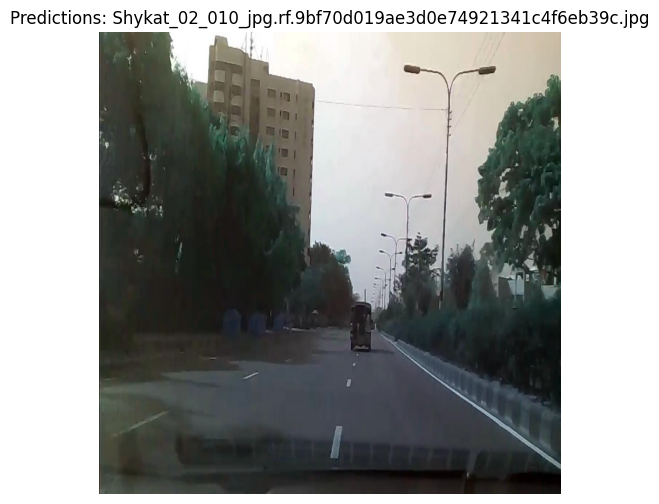


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (15)_jpg.rf.c0508776a64778170e7f71c95db370e5.jpg: 640x640 1 car, 1 motorbike, 7 rickshaws, 37.1ms
Speed: 4.8ms preprocess, 37.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


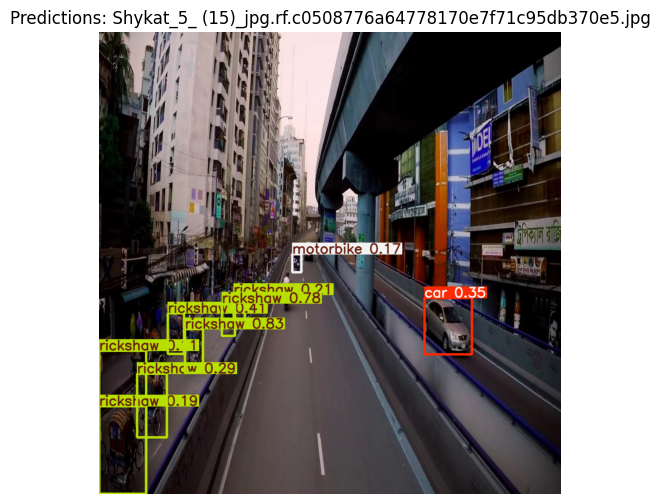


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (56)_jpg.rf.8942f973923b65f8d6f0e598668cee97.jpg: 640x640 1 car, 37.2ms
Speed: 5.8ms preprocess, 37.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


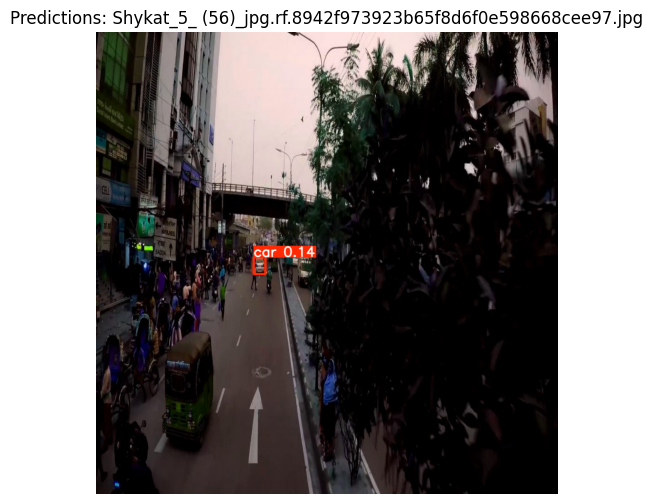


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_5_ (82)_jpg.rf.f9ebdd8a5e7627628dc6b4a7fb688419.jpg: 640x640 3 cars, 2 motorbikes, 2 rickshaws, 37.1ms
Speed: 5.0ms preprocess, 37.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


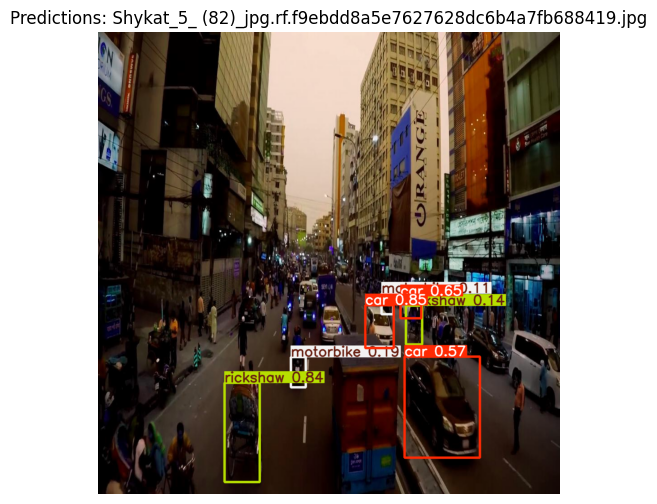


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_02_025_jpg.rf.65e10a8033fb8b4fc6ca9ff5dde4ba26.jpg: 640x640 1 motorbike, 37.1ms
Speed: 5.1ms preprocess, 37.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


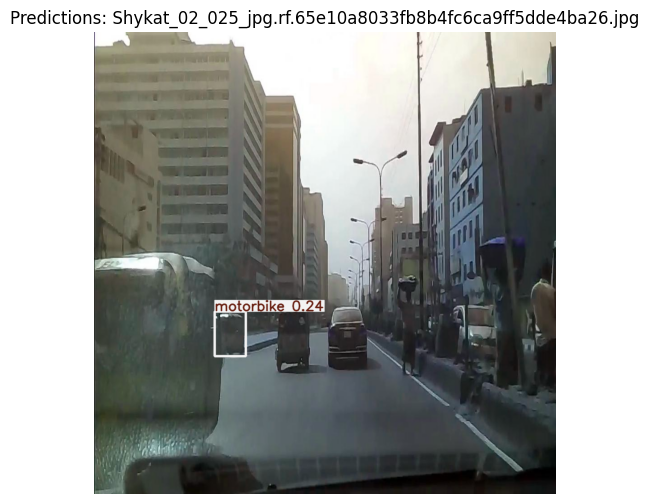


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(281)_jpg.rf.7c528a33de06a0ee9c86d6b09f5f556e.jpg: 640x640 1 bus, 37.2ms
Speed: 5.9ms preprocess, 37.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


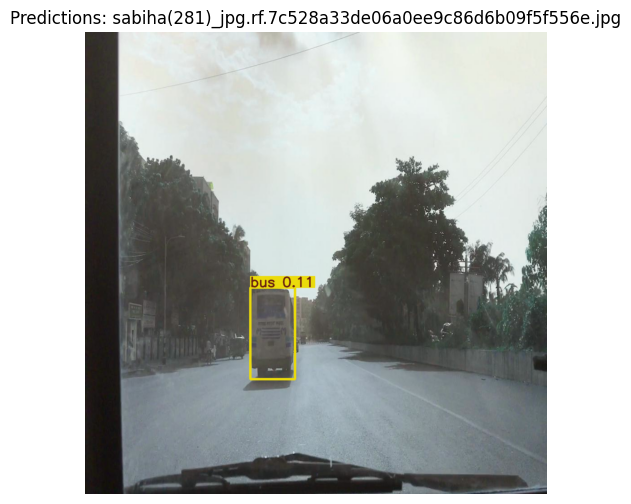


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (28)_jpg.rf.c057111062d7a008142e120963471e17.jpg: 640x640 2 cars, 3 motorbikes, 37.2ms
Speed: 5.4ms preprocess, 37.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


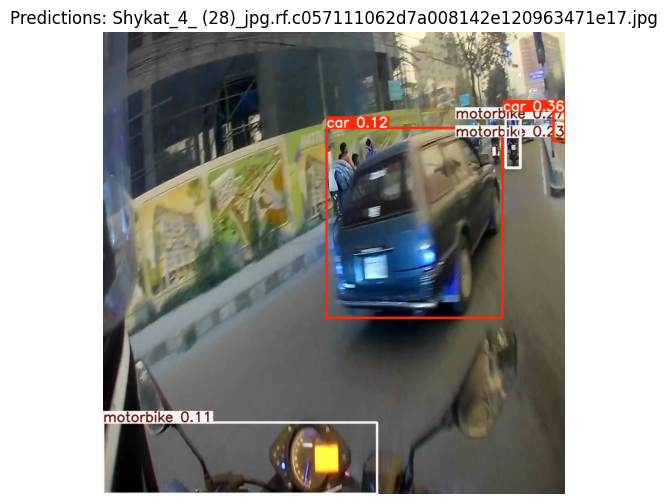


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/sabiha(152)_jpg.rf.9b892eefb41c2860e3313ddb2609fa2c.jpg: 640x640 1 car, 5 rickshaws, 37.1ms
Speed: 5.4ms preprocess, 37.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


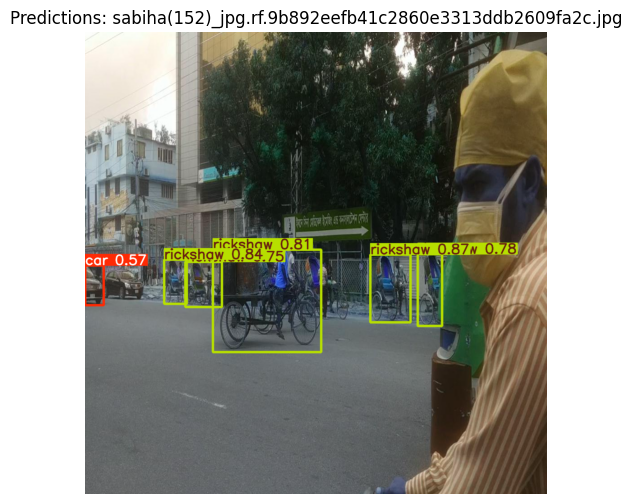


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (50)_jpg.rf.2e08af2776407f6449bcfc37c532acbd.jpg: 640x640 1 motorbike, 37.1ms
Speed: 5.5ms preprocess, 37.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


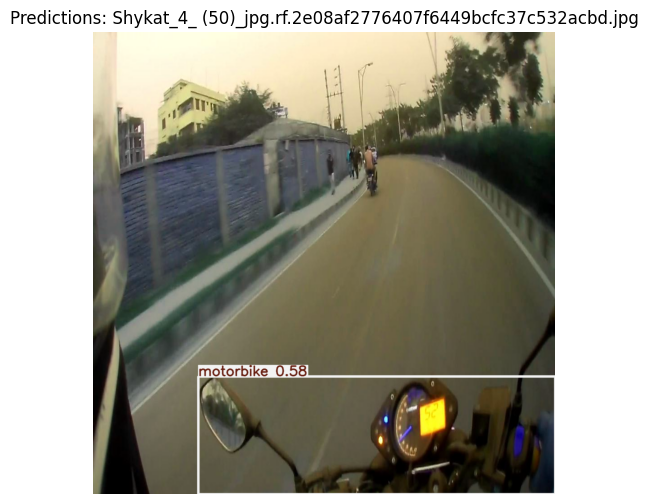


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Sabiha_(51)_jpg.rf.079d042735b2e15f2e6a388ec482fe5a.jpg: 640x640 3 cars, 2 buss, 37.1ms
Speed: 5.2ms preprocess, 37.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


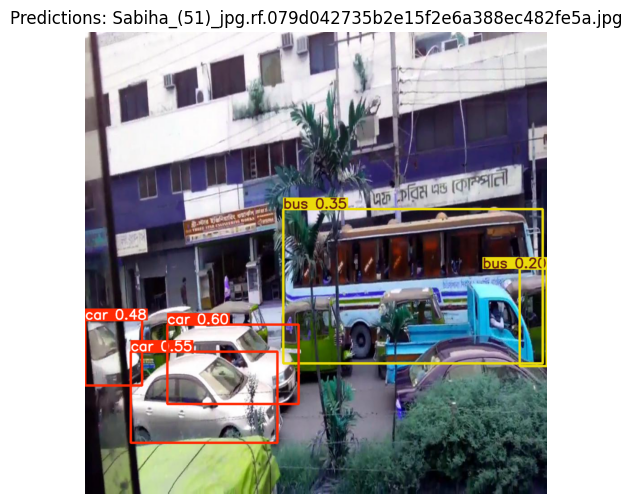


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_4_ (11)_jpg.rf.35080f7fe5c665674eb04290f0df1f8d.jpg: 640x640 3 motorbikes, 37.2ms
Speed: 5.6ms preprocess, 37.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


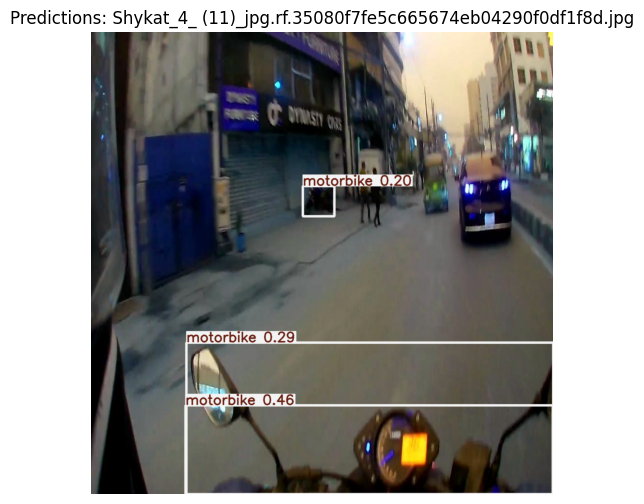


image 1/1 /root/.cache/kagglehub/datasets/pratikbarua/vehicle-detection-dataset/versions/1/test1/test/Shykat_03_023_jpg.rf.a443eee6c1a35f2a07d69c8e5f79125c.jpg: 640x640 2 cars, 1 rickshaw, 37.1ms
Speed: 4.8ms preprocess, 37.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


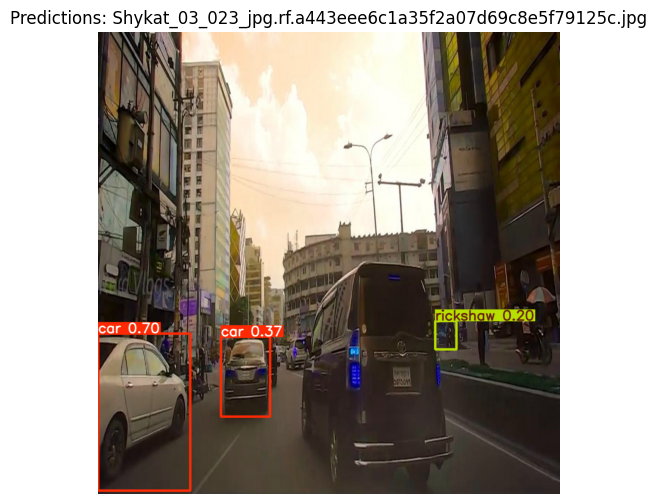

In [ ]:
for img_path in test_images[1:13]:
    results = model.predict(str(img_path), imgsz=IMG_SIZE,conf=0.1)
    annotated_img = results[0].plot()
    plt.figure(figsize=(10, 6))
    plt.imshow(annotated_img)
    plt.title(f"Predictions: {img_path.name}")
    plt.axis('off')
    plt.show()

Interpretation

In the first 13 test images, the model demonstrated strong performance by accurately detecting the chosen vehicle classes (car, bus, motorbike, and rickshaw). In some cases, an image was displayed without any detections, which is expected when none of the chosen classes are present in that image. However, in the 5th image, the model misclassified an object as a motorbike, likely due to poor image resolution or visual similarity to the target class. Overall, considering the model was trained for 50 epochs, its detection performance is satisfactory and shows good generalization to the test set.